# 집값 예측

- Data fields
    - ID : 집을 구분하는 번호 (train set에서만 삭제)
    - zipcode : 우편번호 (삭제)
    - price : 집의 가격(Target variable)
    - date : 집을 구매한 날짜
    - bedrooms : 침실의 수
    - bathrooms : 침실 개수 당 화장실의 수(화장실의 수 / 침실의 수 )
    - floors : 집의 층 수
    - waterfront : 집의 전방에 강이 흐르는지 유무 (a.k.a. 리버뷰)
    - view : 집이 얼마나 좋아 보이는지의 정도
    - condition : 집의 전반적인 상태  
    - grade : King County grading 시스템 기준으로 매긴 집의 등급   
    - yr_built : 지어진 년도 
    - yr_renovated : 집을 재건축한 년도
    - lat : 위도
    - long : 경도
    - 아래 둘이 합치기
        - sqft_above : 지하실을 제외한 평방 피트(면적)
        - sqft_basement : 지하실의 평방 피트(면적)  
    - 거래일 14년인지 15년인지에 따라 다르게 적용
        - sqft_living : 주거 공간의 평방 피트(면적)
        - sqft_lot : 부지의 평방 피트(면적)
        - sqft_living15 : 2015년 기준 주거 공간의 평방 피트(면적, 집을 재건축했다면, 변화가 있을 수 있음)
        - sqft_lot15 : 2015년 기준 부지의 평방 피트(면적, 집을 재건축했다면, 변화가 있을 수 있음)

- lat, long, distance로 

In [2]:
# machine learning : train, test set
from sklearn.model_selection import train_test_split

# machine learning : Regressor
from sklearn.ensemble import RandomForestRegressor
from sklearn.svm import SVR
from sklearn.tree import DecisionTreeRegressor

In [3]:
import warnings
warnings.filterwarnings('ignore')

In [4]:
from preprocessing_module import *
from Genetic_algorithm import genetic_algorithm

In [5]:
def functions_list():
    '''preprocessing_module 의 함수 list 출력'''
    from inspect import getmembers, isfunction
    import preprocessing_module
    
    return [o[0] for o in getmembers(preprocessing_module) if isfunction(o[1])]

In [6]:
functions_list()

['Remove_outliers',
 'categ_or_contin',
 'check_skew',
 'corr_btw_x_y_VS_fixed_col',
 'corr_heatmap',
 'count_category',
 'features_Boxplot',
 'features_vs_frequency',
 'features_vs_label',
 'functions_list',
 'one_feature_vs_freqency',
 'rmse',
 'rowXcol_for_subfig',
 'skew',
 'test_for_transf',
 'x_vs_y_with_fixed_col']

In [6]:
#%whos

## train data, test data 불러오기

In [1]:
import os
os.chdir('/Users/yongwan89/PycharmProjects/dataset')

In [2]:
# train data, test data 불러오기
house_train = pd.read_csv("house_train.csv", engine = 'python')
house_test = pd.read_csv("house_test.csv", engine = 'python')
house = [house_train.copy(), house_test.copy()]

## id drop / date 숫자로 변환

In [8]:
for i in range(len(house)):
    # house의 id 드랍
    house[i].drop(columns= ['id'], inplace = True)
    # date(구매시기) 데이터 줄여주기 ex) 20141013T000000 -> 20141013 ->2014.1013  
    #(구매와 건축 시기 차이 구할 때 유용)
    house[i]['date'] = [round(int(house[i]['date'].iloc[j][:8])/10000, 4) \
                        for j in range(len(house[i]))]
    # price 정규화 0 < price < 1
    #house[0]['price'] = house[0]['price'] #test set에는 price없으니 train set만 정규화

In [9]:
#NAN 존재여부 테스트
for i in range(len(house)):
    test = house[i].isnull().sum().sum()  
    if test == 0:
        print('house[{}] : NAN 데이터 없음.'.format(i))
    else:
        print('house[{}] : NAN 데이터가 {}개 있음.'.format(i, test))
# Nan 없음.

house[0] : NAN 데이터 없음.
house[1] : NAN 데이터 없음.


In [10]:
house[0][house[0]['bathrooms']==0]

date     price  bedrooms  bathrooms  sqft_living  sqft_lot  \
4123   2014.1104  280000.0         1        0.0          600     24501   
6885   2014.1223  235000.0         0        0.0         1470      4800   
7322   2014.0918  484000.0         1        0.0          690     23244   
13522  2014.0926  142000.0         0        0.0          290     20875   

       floors  waterfront  view  condition  grade  sqft_above  sqft_basement  \
4123      1.0           0     0          2      3         600              0   
6885      2.0           0     0          3      7        1470              0   
7322      1.0           0     0          4      7         690              0   
13522     1.0           0     0          1      1         290              0   

       yr_built  yr_renovated  zipcode      lat     long  sqft_living15  \
4123       1950             0    98045  47.5316 -121.749            990   
6885       1996             0    98065  47.5265 -121.828           1060   
7322       1948             0    98053  47.6429 -121.955           1690   
13522      1963             0    98024  47.5308 -121.888           1620   

       sqft_lot15  
4123        22549  
6885         7200  
7322        19290  
13522       22850

## 상관관계 조사

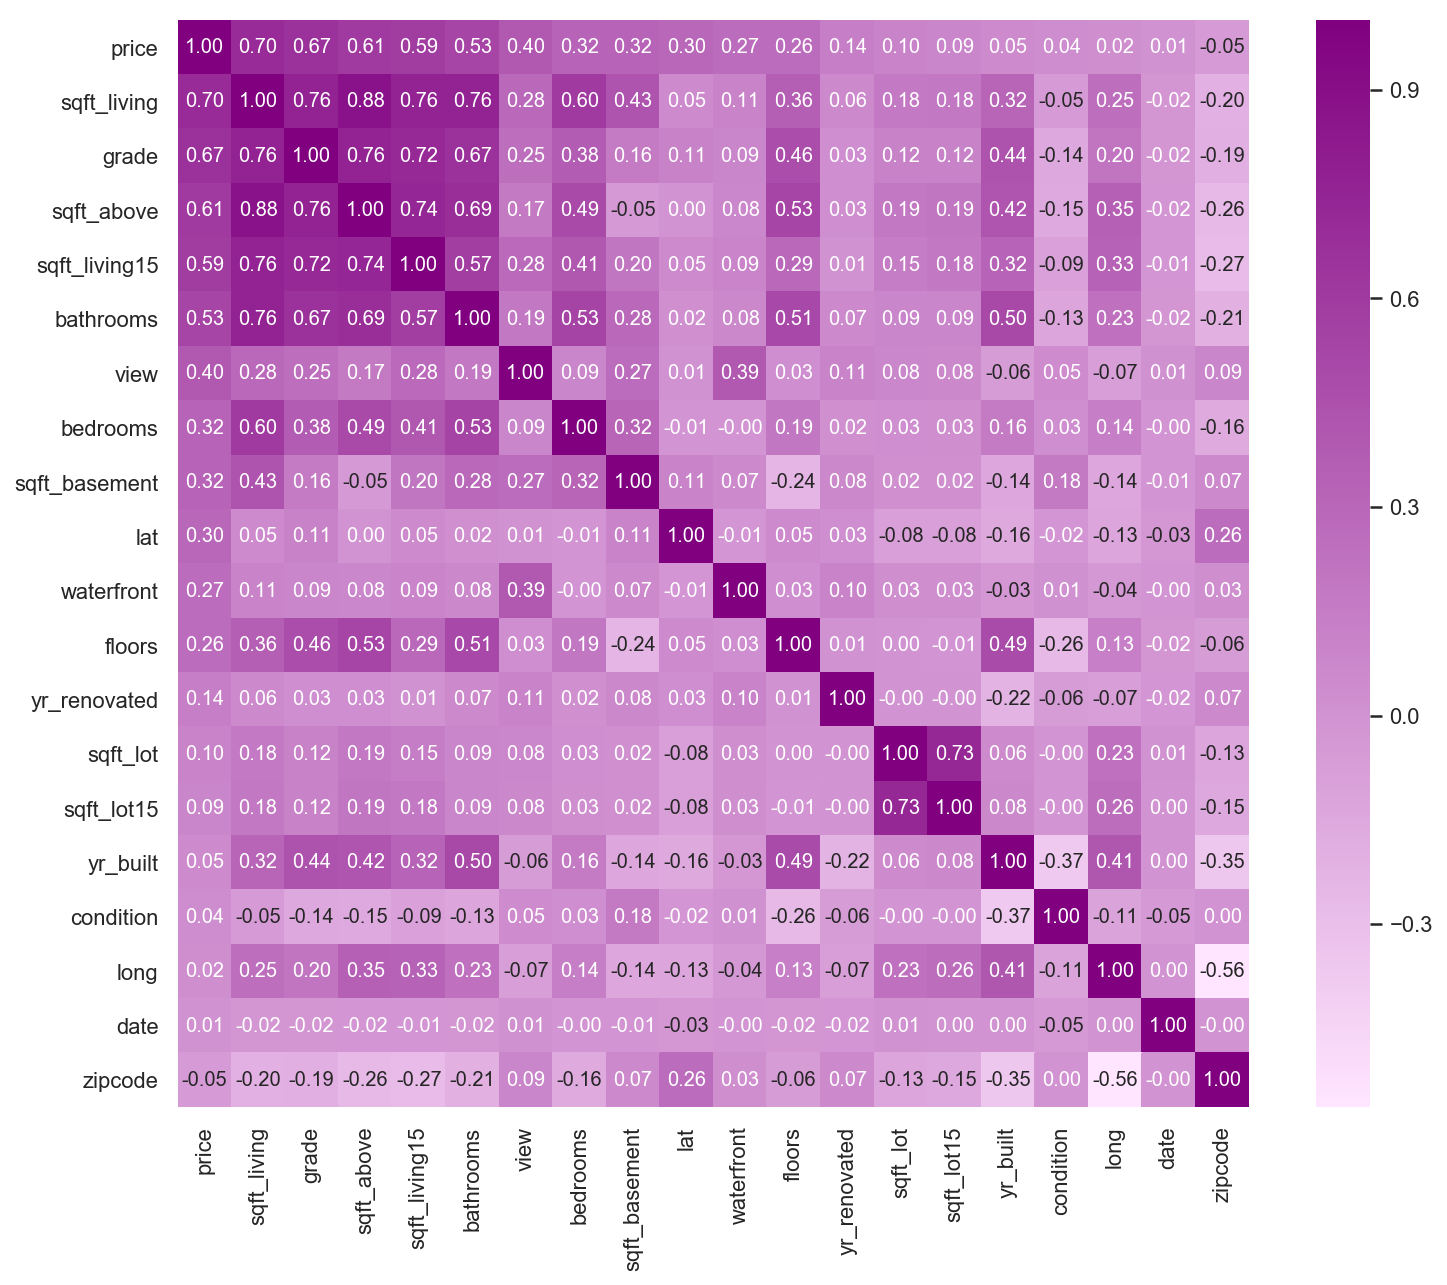

In [11]:
corr_heatmap(house[0], 'price')

### #. zipcode : 삭제 (보류)
- zipcode는 위치와 상관이 없다.
- 같은 zipcode를 가지는 집들 중 (위도, 경도)를 구글 지도에 찍어보면 서로 완전 다른 지역을 나타내고 있다.
- 따라서 zipcode는 무의미한 정보이다.
- 완료 데이터 : house1

In [12]:
count_category(house[0],['zipcode']).tail()

category  zipcode
65     98102       75
66     98010       63
67     98024       54
68     98148       44
69     98039       36

그래프가 1X1행렬로 그려집니다.


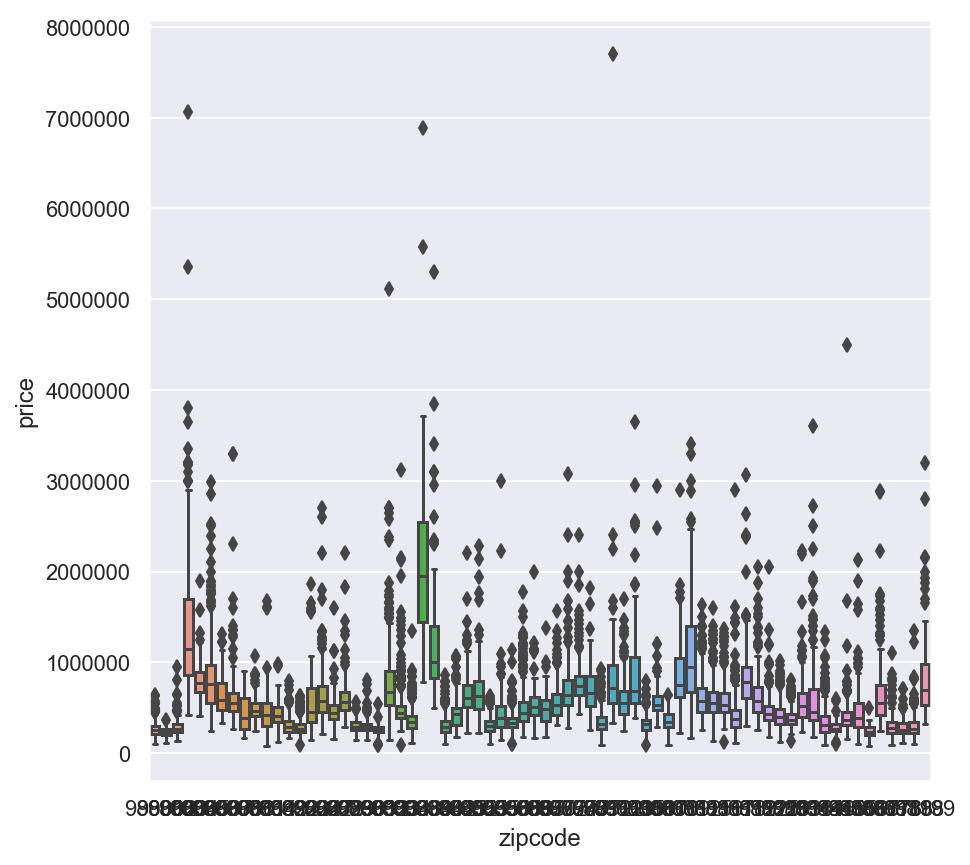

In [13]:
features_Boxplot(house[0],'price',['zipcode'],figsize_tuple_=(7,7))

Skewness: 0.405891


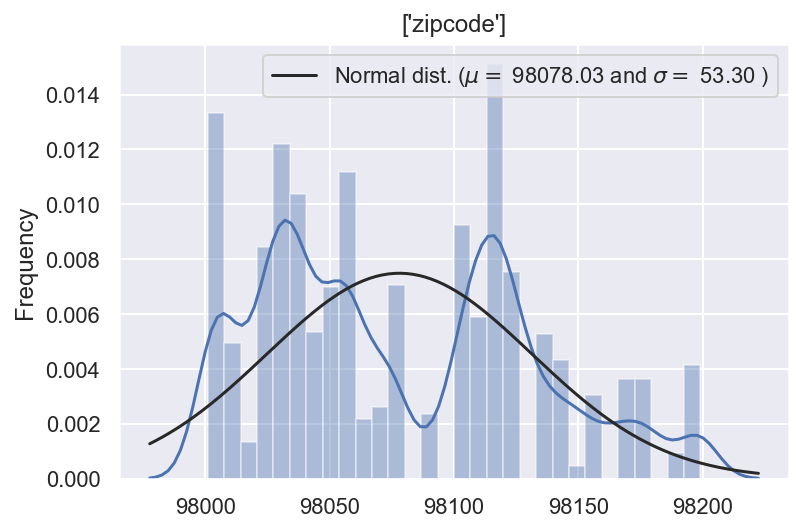

In [14]:
one_feature_vs_freqency(house[0],['zipcode'])

그래프가 1X2행렬로 그려집니다.


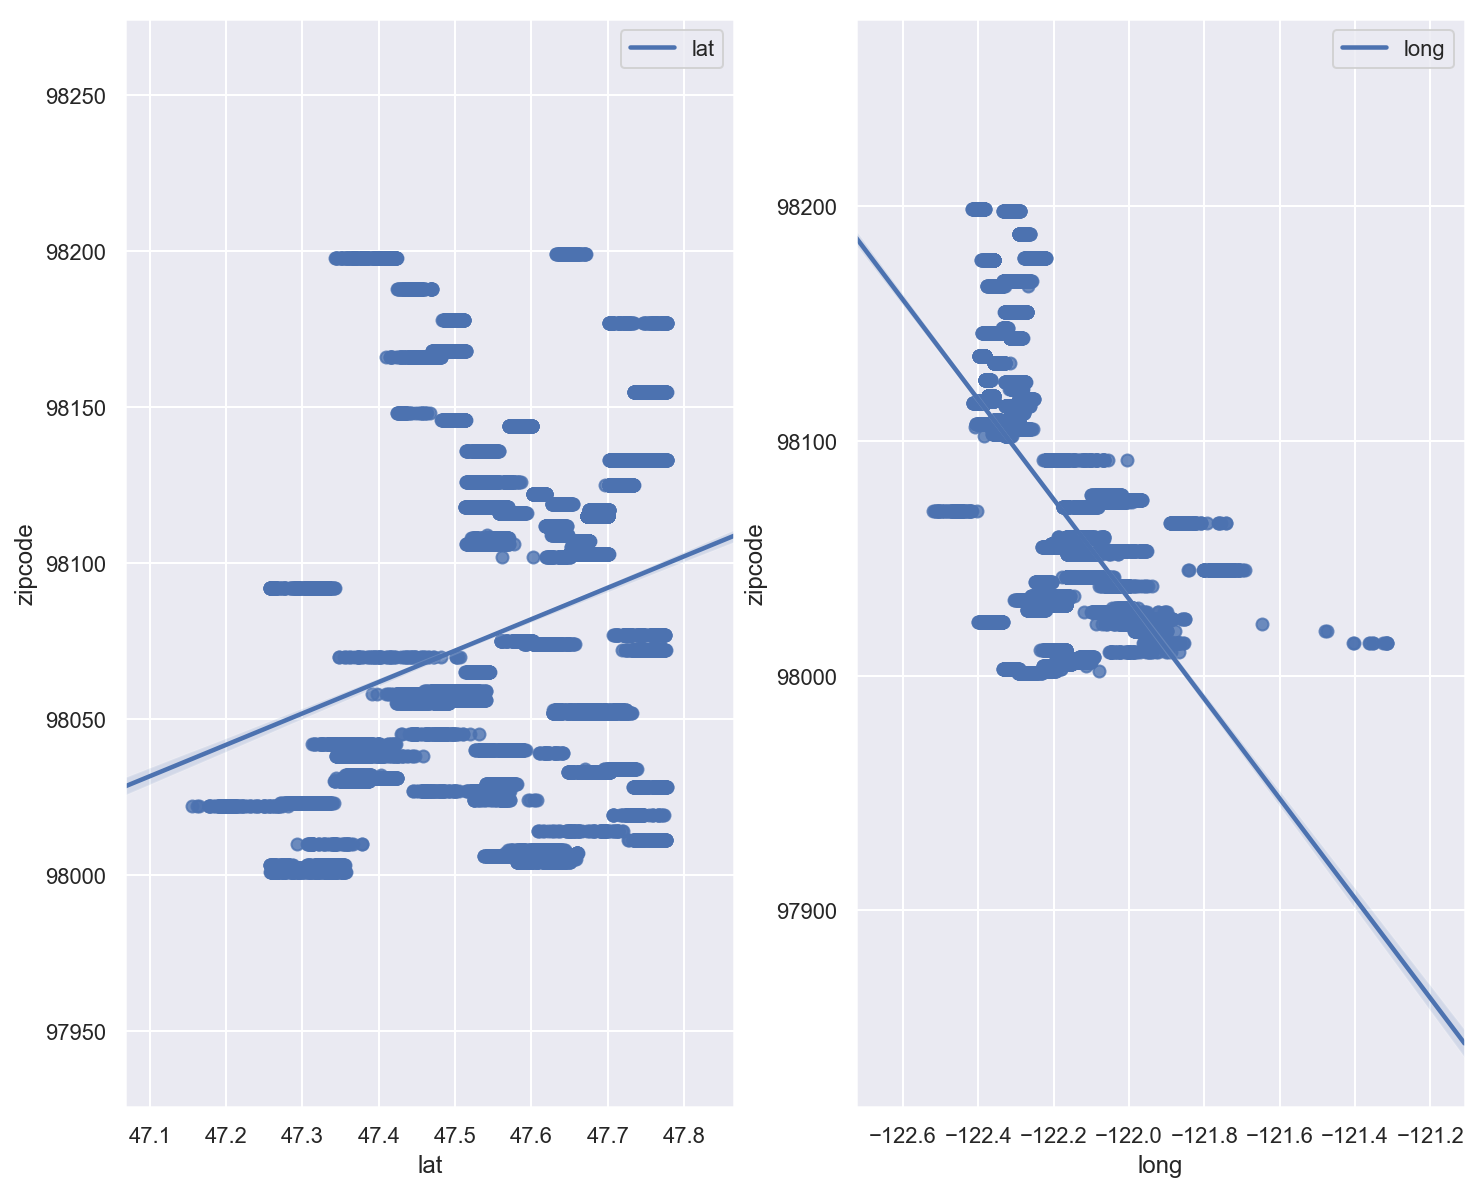

In [15]:
features_vs_label(house[0],'zipcode',['lat', 'long'])

In [16]:
# zipcode와 (위도, 경도) 정보 조사
for i in range(len(house)):
    h_zip = house[i][['zipcode', 'lat', 'long']].sort_values(by = ['zipcode'])\
    .reset_index(drop=True).head()
    print(h_zip)

   zipcode      lat     long
0    98001  47.3530 -122.294
1    98001  47.2619 -122.271
2    98001  47.3318 -122.277
3    98001  47.3359 -122.257
4    98001  47.3524 -122.285
   zipcode      lat     long
0    98001  47.3398 -122.286
1    98001  47.2849 -122.251
2    98001  47.2871 -122.287
3    98001  47.3427 -122.274
4    98001  47.3260 -122.273


- Zipcode 삭제 일단 보류

In [17]:
#zipcode 삭제
# house1 = []
# for i in range(len(house)):
#     house1.append(house[i].drop(columns=['zipcode']).copy())


In [18]:
house[0].head()

date     price  bedrooms  bathrooms  sqft_living  sqft_lot  floors  \
0  2014.1013  221900.0         3       1.00         1180      5650     1.0   
1  2015.0225  180000.0         2       1.00          770     10000     1.0   
2  2015.0218  510000.0         3       2.00         1680      8080     1.0   
3  2014.0627  257500.0         3       2.25         1715      6819     2.0   
4  2015.0115  291850.0         3       1.50         1060      9711     1.0   

   waterfront  view  condition  grade  sqft_above  sqft_basement  yr_built  \
0           0     0          3      7        1180              0      1955   
1           0     0          3      6         770              0      1933   
2           0     0          3      8        1680              0      1987   
3           0     0          3      7        1715              0      1995   
4           0     0          3      7        1060              0      1963   

   yr_renovated  zipcode      lat     long  sqft_living15  sqft_lot15  
0             0    98178  47.5112 -122.257           1340        5650  
1             0    98028  47.7379 -122.233           2720        8062  
2             0    98074  47.6168 -122.045           1800        7503  
3             0    98003  47.3097 -122.327           2238        6819  
4             0    98198  47.4095 -122.315           1650        9711

In [19]:
#feature selection

# random_forest = RandomForestRegressor(n_estimators= 120, min_samples_leaf= 1, max_depth= 20,random_state=42)

# test = genetic_algorithm(house[0], n=10, k=5, iter_number=10,fit_model = random_forest, \
#                          label_in_df ='price', metric_scoring = 'r2')
                         
#Index(['date', 'sqft_living', 'sqft_lot', 'waterfront', 'view', 'condition','grade', 'sqft_above', 
# 'sqft_basement', 'zipcode', 'lat', 'long'],
 #     dtype='object') 0.8722855702330345         

### #. sqft_lot, sqft_living 전처리
- 거래일이 14년인 것은 sqft_lot, living을 사용
- 거래일이 15년인 것은 sqft_lot15, living15로 사용
- house2

In [23]:
# 'sqft_lot,living15'과 'sqft_lot,living' 중 년도 구분해서 적절한 sqft 적용
house2 = []
for i in range(len(house1)):
    h_2014 = house1[i][house1[i]['date'] < 2015].drop(columns = ['sqft_living15', 'sqft_lot15'])
    h_2015 = house1[i][house1[i]['date'] >= 2015].drop(columns = ['sqft_living', 'sqft_lot'])\
        .rename(columns={'sqft_living15' : 'sqft_living', 'sqft_lot15' : 'sqft_lot'})
    house2.append(pd.concat([h_2015,h_2014],axis=0, sort=False).sort_index())

In [24]:
house2[0].head()

date     price  bedrooms  bathrooms  floors  waterfront  view  \
0  2014.1013  221900.0         3       1.00     1.0           0     0   
1  2015.0225  180000.0         2       1.00     1.0           0     0   
2  2015.0218  510000.0         3       2.00     1.0           0     0   
3  2014.0627  257500.0         3       2.25     2.0           0     0   
4  2015.0115  291850.0         3       1.50     1.0           0     0   

   condition  grade  sqft_above  sqft_basement  yr_built  yr_renovated  \
0          3      7        1180              0      1955             0   
1          3      6         770              0      1933             0   
2          3      8        1680              0      1987             0   
3          3      7        1715              0      1995             0   
4          3      7        1060              0      1963             0   

       lat     long  sqft_living  sqft_lot  
0  47.5112 -122.257         1180      5650  
1  47.7379 -122.233         2720      8062  
2  47.6168 -122.045         1800      7503  
3  47.3097 -122.327         1715      6819  
4  47.4095 -122.315         1650      9711

### #. sqft_above + sqft_basement
- 전체 평수(sqft_total = sqft_above와 sqft_basement) 계산
- sqft_above와 sqft_basement는 삭제
- 근데 이게 sqft living보다 값이 작아서 뭐가 맞는건지 모르겠음. (추후에 지워야할수도)
- house3

In [25]:
house3 = []
for i in range(len(house2)):
    house3.append(house2[i].copy())
    house3[i]['sqft_total'] = house3[i]['sqft_above']+house3[i]['sqft_basement']
    house3[i].drop(columns = ['sqft_above', 'sqft_basement'], inplace = True)

In [26]:
house3[0].head()

date     price  bedrooms  bathrooms  floors  waterfront  view  \
0  2014.1013  221900.0         3       1.00     1.0           0     0   
1  2015.0225  180000.0         2       1.00     1.0           0     0   
2  2015.0218  510000.0         3       2.00     1.0           0     0   
3  2014.0627  257500.0         3       2.25     2.0           0     0   
4  2015.0115  291850.0         3       1.50     1.0           0     0   

   condition  grade  yr_built  yr_renovated      lat     long  sqft_living  \
0          3      7      1955             0  47.5112 -122.257         1180   
1          3      6      1933             0  47.7379 -122.233         2720   
2          3      8      1987             0  47.6168 -122.045         1800   
3          3      7      1995             0  47.3097 -122.327         1715   
4          3      7      1963             0  47.4095 -122.315         1650   

   sqft_lot  sqft_total  
0      5650        1180  
1      8062         770  
2      7503        1680  
3      6819        1715  
4      9711        1060

### #. yr_built 처리 : 거래당시 집의 연차 계산 + #. yr_renovated 처리 : 재건축 유무로 변경
- yr_renovated -> yr_built
- yr_renovated 삭제
- 
- 거래당시 지어진지 몇년되었는지 계산.
- round(date,0) - yr_built
- 
- 두가지 년도 관련 전처리 후 데이터 : house4

In [27]:
# 거래당시 집의 연차 계산
house4 = []
for i in range(len(house3)):
    house4.append(house3[i].copy())
    house4[i]['yr_built'] = round(house4[i]['date'], 0) - house4[i]['yr_built']

Skewness: -1.004152


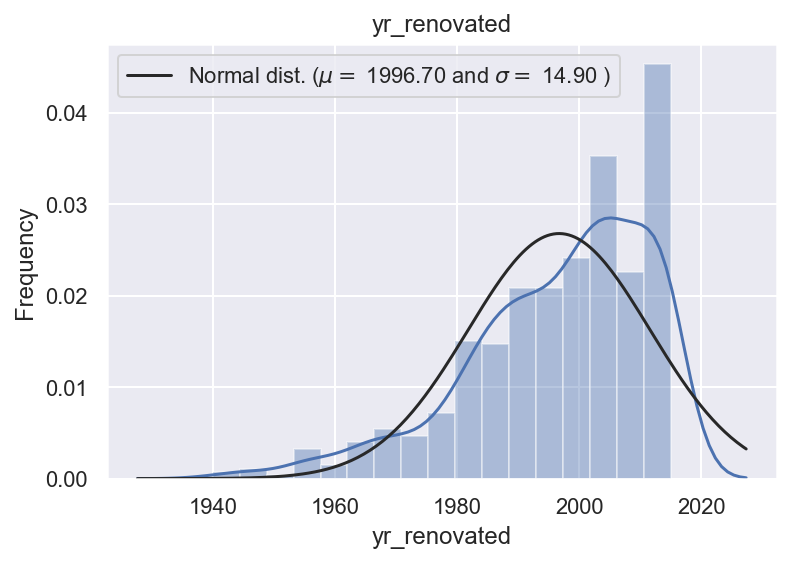

In [28]:
one_feature_vs_freqency(house4[0][house4[0]['yr_renovated']!=0],'yr_renovated')
# 재건축을 한 집들의 분포

In [27]:
# 거래당시 집의 연차 계산
house4 = []
for i in range(len(house3)):
    house4.append(house3[i].copy())
    house4[i]['yr_built'] = round(house4[i]['date'], 0) - house4[i]['yr_built']

그래프가 1X1행렬로 그려집니다.


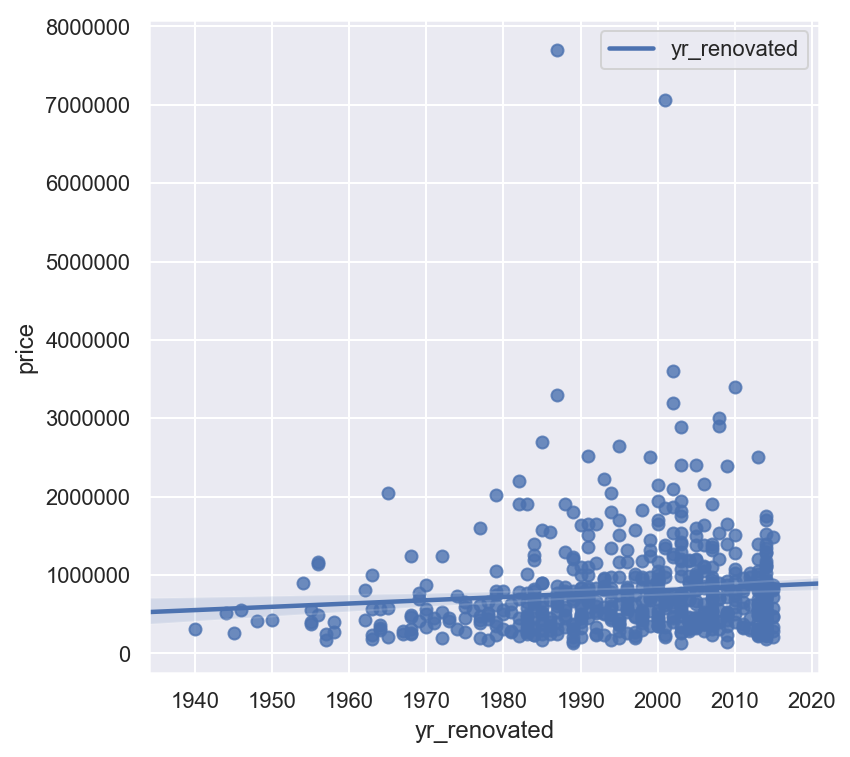

In [29]:
features_vs_label(house4[0][house4[0]['yr_renovated']!=0],'price',['yr_renovated'],figsize_tuple_=(6,6))
# 재건축한 집들만 보면 뭔가 분포가 관련이 있을거 같기도..

In [32]:
house4[0][house4[0]['yr_renovated']!=0]['yr_built']=house4[0]['yr_renovated']

In [33]:
house4[0]

date      price  bedrooms  bathrooms  floors  waterfront  view  \
0      2014.1013   221900.0         3       1.00     1.0           0     0   
1      2015.0225   180000.0         2       1.00     1.0           0     0   
2      2015.0218   510000.0         3       2.00     1.0           0     0   
3      2014.0627   257500.0         3       2.25     2.0           0     0   
4      2015.0115   291850.0         3       1.50     1.0           0     0   
5      2015.0403   662500.0         3       2.50     1.0           0     0   
6      2014.0527   468000.0         2       1.00     1.0           0     0   
7      2014.0528   310000.0         3       1.00     1.5           0     0   
8      2014.1007   400000.0         3       1.75     1.0           0     0   
9      2015.0312   530000.0         5       2.00     1.5           0     0   
10     2015.0124   650000.0         4       3.00     2.0           0     3   
11     2014.0731   395000.0         3       2.00     2.0           0     0   
12     2014.0529   485000.0         4       1.00     1.5           0     0   
13     2014.1205   189000.0         2       1.00     1.0           0     0   
14     2015.0424   230000.0         3       1.00     1.0           0     0   
15     2014.0514   385000.0         4       1.75     1.0           0     0   
16     2014.0826  2000000.0         3       2.75     1.0           0     4   
17     2014.0516   252700.0         2       1.50     1.0           0     0   
18     2014.1120   329000.0         3       2.25     2.0           0     0   
19     2014.1103   233000.0         3       2.00     1.5           0     0   
20     2014.0626   937000.0         3       1.75     2.0           0     0   
21     2014.1201   667000.0         3       1.00     1.5           0     0   
22     2014.1110   580500.0         3       2.50     2.0           0     0   
23     2014.0624   687500.0         4       1.75     1.5           0     0   
24     2014.1110   535000.0         3       1.00     1.5           0     0   
25     2014.1203   322500.0         4       2.75     1.0           0     0   
26     2014.0613   696000.0         3       2.50     1.5           0     0   
27     2014.1230   640000.0         4       2.00     2.0           0     0   
28     2015.0213   240000.0         4       1.00     1.0           0     0   
29     2014.0620   605000.0         4       2.50     2.0           0     0   
...          ...        ...       ...        ...     ...         ...   ...   
15005  2014.0513   330000.0         3       2.50     1.0           0     0   
15006  2015.0502   608500.0         4       3.50     2.0           0     0   
15007  2014.0520   785000.0         4       3.50     2.0           0     0   
15008  2014.0507   610950.0         3       3.00     3.0           0     0   
15009  2014.1111   399950.0         3       2.50     2.0           0     0   
15010  2015.0123   579000.0         4       3.25     2.0           0     0   
15011  2014.0623   362500.0         2       1.50     2.0           0     0   
15012  2014.0529   645000.0         3       3.25     2.0           0     2   
15013  2014.1003   594866.0         3       3.00     2.0           0     0   
15014  2014.1112   490000.0         3       2.25     2.0           0     0   
15015  2014.0610   399950.0         2       1.00     2.0           0     0   
15016  2014.0828   270000.0         3       2.50     2.0           0     0   
15017  2014.1015   505000.0         2       2.50     3.0           0     0   
15018  2015.0305   385000.0         3       2.50     3.0           0     0   
15019  2014.1113   414500.0         2       1.50     2.0           0     0   
15020  2014.0910   347500.0         3       2.50     2.0           0     0   
15021  2014.0514  1222500.0         4       3.50     1.5           0     0   
15022  2015.0317  1088000.0         5       3.75     2.0           0     2   
15023  2014.1017   350000.0         4       2.75     2.0           0     0   
15024  2014.0813   679950.0       

In [25]:
# for i in range(len(house4)):
#     house4[i]['yr_renovated'][house4[i]['yr_renovated'] == 0] = 0
#     house4[i]['yr_renovated'][house4[i]['yr_renovated'] != 0] = 1

### !!!! 이상치. 거래일(date)보다 건축일(yr_built)가 더 나중임. 지어지기전에 거래??

### #. yr_built 처리 : 거래당시 집의 연차 계산 + #. yr_renovated 처리 : 재건축 유무로 변경
- 거래당시 지어진지 몇년되었는지 계산.
- round(date,0) - yr_built
- 재건축 유 = 1 /  재건축 무 = 0 
- 두가지 년도 관련 전처리 후 데이터 : house4

In [71]:
# 거래당시 집의 연차 계산
house4 = []
for i in range(len(house3)):
    house4.append(house3[i].copy())

Skewness: -1.004152


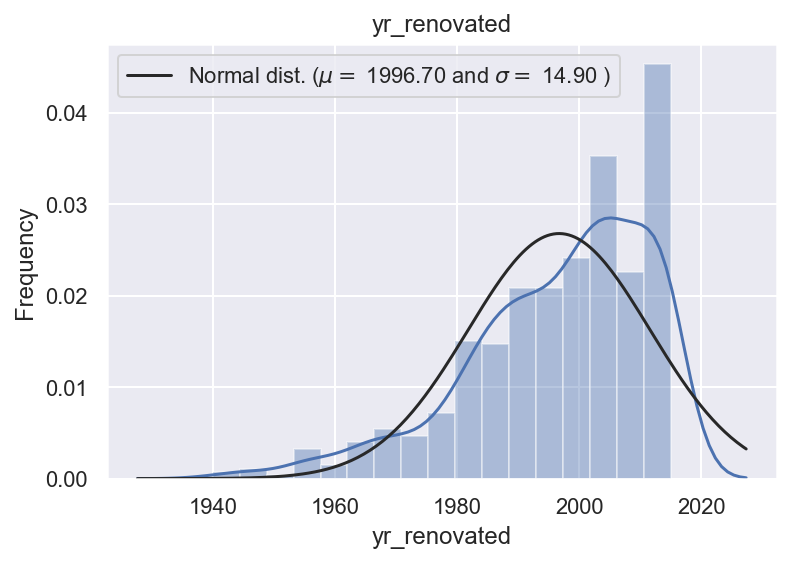

In [35]:
one_feature_vs_freqency(house4[0][house4[0]['yr_renovated']!=0],'yr_renovated')
# 재건축을 한 집들의 분포

그래프가 1X1행렬로 그려집니다.


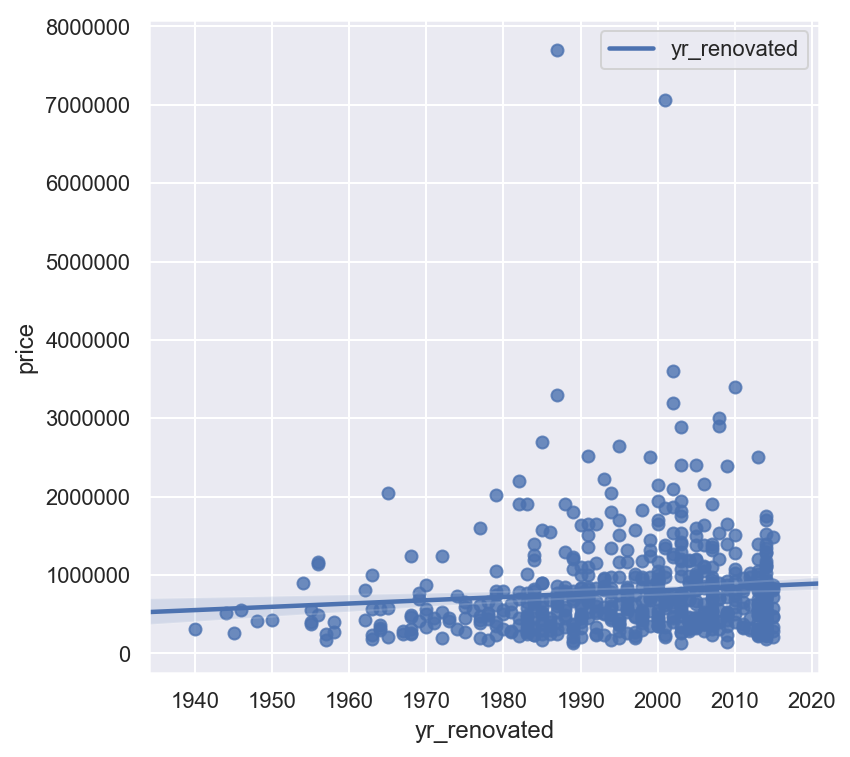

In [36]:
features_vs_label(house4[0][house4[0]['yr_renovated']!=0],'price',['yr_renovated'],figsize_tuple_=(6,6))
# 재건축한 집들만 보면 뭔가 분포가 관련이 있을거 같기도..

- yr_renovated -> yr_built

In [72]:
house4[0][house4[0]['yr_renovated']!=0].head()

date      price  bedrooms  bathrooms  floors  waterfront  view  \
26   2014.0613   696000.0         3       2.50     1.5           0     0   
78   2014.1121   740500.0         3       3.50     2.0           0     0   
149  2015.0221  1505000.0         5       3.00     1.0           0     3   
160  2015.0413   655000.0         2       1.75     2.0           1     4   
166  2015.0320   410000.0         4       1.00     1.5           0     0   

     condition  grade  yr_built  yr_renovated      lat     long  sqft_living  \
26           3      8      1930          2002  47.6827 -122.310         2300   
78           3      8      1900          1999  47.6981 -122.368         4380   
149          3      9      1957          1991  47.5673 -122.210         3836   
160          3      7      1915          1978  47.4497 -122.375         2030   
166          3      7      1904          2005  47.6136 -122.303         1510   

     sqft_lot  sqft_total  
26       3060        2300  
78       6350        4380  
149     20953        3300  
160     13193        1450  
166      4740        1970

In [73]:
for i in range(len(house4)):
    idx_1 = house4[i][house4[i]['yr_renovated']!=0].index
    house4[i]['yr_built'].iloc[idx_1] = house4[i]['yr_renovated'].iloc[idx_1]
    house4[i].drop(columns=['yr_renovated'], inplace=True)

In [76]:
# 거래당시 집의 연차 계산
for i in range(len(house4)):
    house4[i]['yr_built'] = round(house4[i]['date'], 0) - house4[i]['yr_built']

In [83]:
house4[0].head()

date     price  bedrooms  bathrooms  floors  waterfront  view  \
0  2014.1013  221900.0         3       1.00     1.0           0     0   
1  2015.0225  180000.0         2       1.00     1.0           0     0   
2  2015.0218  510000.0         3       2.00     1.0           0     0   
3  2014.0627  257500.0         3       2.25     2.0           0     0   
4  2015.0115  291850.0         3       1.50     1.0           0     0   

   condition  grade  yr_built      lat     long  sqft_living  sqft_lot  \
0          3      7      59.0  47.5112 -122.257         1180      5650   
1          3      6      82.0  47.7379 -122.233         2720      8062   
2          3      8      28.0  47.6168 -122.045         1800      7503   
3          3      7      19.0  47.3097 -122.327         1715      6819   
4          3      7      52.0  47.4095 -122.315         1650      9711   

   sqft_total  
0        1180  
1         770  
2        1680  
3        1715  
4        1060

In [25]:
# for i in range(len(house4)):
#     house4[i]['yr_renovated'][house4[i]['yr_renovated'] == 0] = 0
#     house4[i]['yr_renovated'][house4[i]['yr_renovated'] != 0] = 1

Skewness: 0.554051


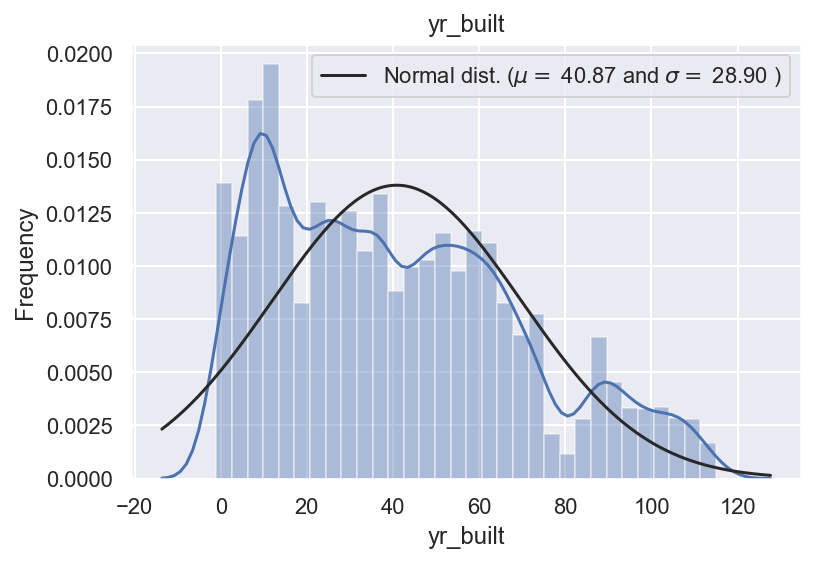

In [78]:
one_feature_vs_freqency(house4[0],'yr_built')

In [81]:
idx_built_outliers = house4[0]['yr_built'][house4[0]['yr_built']==-1].index
idx_built_outliers2 = house4[1]['yr_built'][house4[1]['yr_built']==-1].index
idx_built_outliers

Int64Index([ 1264,  1641,  1920,  5002,  5303,  5654, 10110, 11890, 12907,
            14428, 14484, 14563, 14776],
           dtype='int64')

In [84]:
house4[0][['date', 'yr_built','lat','long']].iloc[idx_built_outliers]
# 아래보면 date < yr_built 토지 구매후 짓기 시작했나? 음...

date  yr_built      lat     long
1264   2014.0625      -1.0  47.5784 -122.226
1641   2014.0728      -1.0  47.6388 -122.300
1920   2014.1029      -1.0  47.5756 -122.316
5002   2014.1028      -1.0  47.7412 -122.355
5303   2014.1231      -1.0  47.7685 -122.160
5654   2014.0624      -1.0  47.6001 -122.298
10110  2014.0826      -1.0  47.6514 -122.385
11890  2014.0617      -1.0  47.6074 -122.305
12907  2014.0701      -1.0  47.6763 -122.282
14428  2014.0828      -1.0  47.7384 -122.348
14484  2014.0709      -1.0  47.6725 -122.330
14563  2014.0731      -1.0  47.5951 -122.301
14776  2014.1125      -1.0  47.6611 -122.346

In [87]:
house4[1][['date', 'yr_built']].iloc[idx_built_outliers2]
# 아래보면 date < yr_built 토지 구매후 짓기 시작했나? ㅎㅎ

date  yr_built
3452  2014.0522      -1.0
4413  2014.0606      -1.0
4654  2014.1006      -1.0
5928  2014.0801      -1.0
6407  2014.0520      -1.0

### #. date 전처리 
- 지금의 date 데이터는 2014.1230과 2015.0101사이에 갭이 있다
- date 최솟값 (2014.0502)을 시작으로 월만 더하기 형태로 간다.
- ex) 2014.0502 -> 2014.0502-2014 = 0.0502 -> 5 -> 5 - 4 = 1
- ex) 2015.0102 -> 2015.0102-2015+0.12(2014년의 12달) = 0.1302 -> 13 -> 13-4 = 9

In [88]:
house5 = []
# date년도 순으로 categorical variable로 변환 2014.05.. -> 1
# 데이터들 중 처음 거래가 이루어진 날짜
# h_date_min = house4[0]['date'].min()
for i in range(len(house4)):
    house5.append(house4[i].copy())
#     ex) 2014.0502 -> 2014.0502-2014 = 0.0502 -> 5 -> 5 - 4 = 1
#     ex) 2015.0102 -> 2015.0102-2015+0.12(2014년의 12달) = 0.1302 -> 13 -> 13-4 = 9
    #2014년 건에 대한 연산
    house5[i]['date'][house5[i]['date']<2015] \
            = round((house5[i]['date'][house5[i]['date']<2015]-2014)*100,0) - 4
    #2015년 건에 대한 연산
    house5[i]['date'][house5[i]['date']>2015] \
            = round((house5[i]['date'][house5[i]['date']>2015]-2015+0.12)*100,0) - 4

In [89]:
house5[0][['date']].head()

date
0   6.0
1  10.0
2  10.0
3   2.0
4   9.0

## #. Features의 치우침 해결

In [92]:
house5_1 = []

for i in range(len(house5)):
    house5_1.append(house5[i].copy())

### Categorical var.의 변수 치우침 해결

In [90]:
# catgorical variable들의 분포 파악
count_category(house[0],None, 15, True)

category  bedrooms  category  floors  category  waterfront  category  \
0        0.0       4.0       1.0  7361.0       0.0     14928.0       0.0   
1        1.0     133.0       1.5  1330.0       1.0       107.0       1.0   
2        2.0    1931.0       2.0  5810.0       NaN         NaN       2.0   
3        3.0    6835.0       2.5   113.0       NaN         NaN       3.0   
4        4.0    4797.0       3.0   417.0       NaN         NaN       4.0   
5        5.0    1108.0       3.5     4.0       NaN         NaN       NaN   
6        6.0     188.0       NaN     NaN       NaN         NaN       NaN   
7        7.0      22.0       NaN     NaN       NaN         NaN       NaN   
8        8.0      10.0       NaN     NaN       NaN         NaN       NaN   
9        9.0       5.0       NaN     NaN       NaN         NaN       NaN   
10      10.0       2.0       NaN     NaN       NaN         NaN       NaN   
11       NaN       NaN       NaN     NaN       NaN         NaN       NaN   

       view  category  condition  category  grade  
0   13548.0       1.0       21.0         1      1  
1     241.0       2.0      110.0         3      2  
2     665.0       3.0     9793.0         4     23  
3     373.0       4.0     3956.0         5    174  
4     208.0       5.0     1155.0         6   1406  
5       NaN       NaN        NaN         7   6228  
6       NaN       NaN        NaN         8   4207  
7       NaN       NaN        NaN         9   1855  
8       NaN       NaN        NaN        10    781  
9       NaN       NaN        NaN        11    288  
10      NaN       NaN        NaN        12     61  
11      NaN       NaN        NaN        13      9

In [91]:
# catgorical variable들의 분포 파악
count_category(house[1],None, 15, True)

category  bedrooms  category  floors  category  waterfront  category  \
0          0         9       1.0  3251.0       0.0      6412.0       0.0   
1          1        62       1.5   565.0       1.0        56.0       1.0   
2          2       815       2.0  2406.0       NaN         NaN       2.0   
3          3      2929       2.5    48.0       NaN         NaN       3.0   
4          4      2063       3.0   194.0       NaN         NaN       4.0   
5          5       484       3.5     4.0       NaN         NaN       NaN   
6          6        83       NaN     NaN       NaN         NaN       NaN   
7          7        16       NaN     NaN       NaN         NaN       NaN   
8          8         3       NaN     NaN       NaN         NaN       NaN   
9          9         1       NaN     NaN       NaN         NaN       NaN   
10        10         1       NaN     NaN       NaN         NaN       NaN   
11        11         1       NaN     NaN       NaN         NaN       NaN   
12        33         1       NaN     NaN       NaN         NaN       NaN   

      view  category  condition  category   grade  
0   5837.0       1.0        8.0       3.0     1.0  
1     91.0       2.0       57.0       4.0     6.0  
2    297.0       3.0     4168.0       5.0    62.0  
3    134.0       4.0     1701.0       6.0   611.0  
4    109.0       5.0      534.0       7.0  2701.0  
5      NaN       NaN        NaN       8.0  1843.0  
6      NaN       NaN        NaN       9.0   754.0  
7      NaN       NaN        NaN      10.0   350.0  
8      NaN       NaN        NaN      11.0   108.0  
9      NaN       NaN        NaN      12.0    28.0  
10     NaN       NaN        NaN      13.0     4.0  
11     NaN       NaN        NaN       NaN     NaN  
12     NaN       NaN        NaN       NaN     NaN

# To do!
- grade 1->3 합치기
- condition 1->2합치기
- floors : 3.5 -> 3.0합치기
- bedrooms : 8이상은 다 합치기(test set에는 8,9,10,11,33이 있음) **일단 보류**

In [95]:
for i in range(len(house5_1)):
    idx = house5_1[i][house5_1[i]['grade']==1].index
    house5_1[i]['grade'].iloc[idx] = 3

for i in range(len(house5_1)):
    idx = house5_1[i][house5_1[i]['condition']==1].index
    house5_1[i]['condition'].iloc[idx] = 2

for i in range(len(house5_1)):
    idx = house5_1[i][house5_1[i]['floors']==3.5].index
    house5_1[i]['floors'].iloc[idx] = 3.0

# 범주형 변수 전처리 하기!!

In [99]:
categ_var = categ_or_contin(house5_1[0],15,False,False)
categ_var

['date', 'bedrooms', 'floors', 'waterfront', 'view', 'condition', 'grade']

In [100]:
count_category(house5_1[0],['date'], 15, True)

category  date
0        1.0  1252
1        2.0  1500
2        3.0  1582
3        4.0  1361
4        5.0  1227
5        6.0  1322
6        7.0   981
7        8.0  1004
8        9.0   691
9       10.0   842
10      11.0  1300
11      12.0  1525
12      13.0   448

그래프가 3X3행렬로 그려집니다.


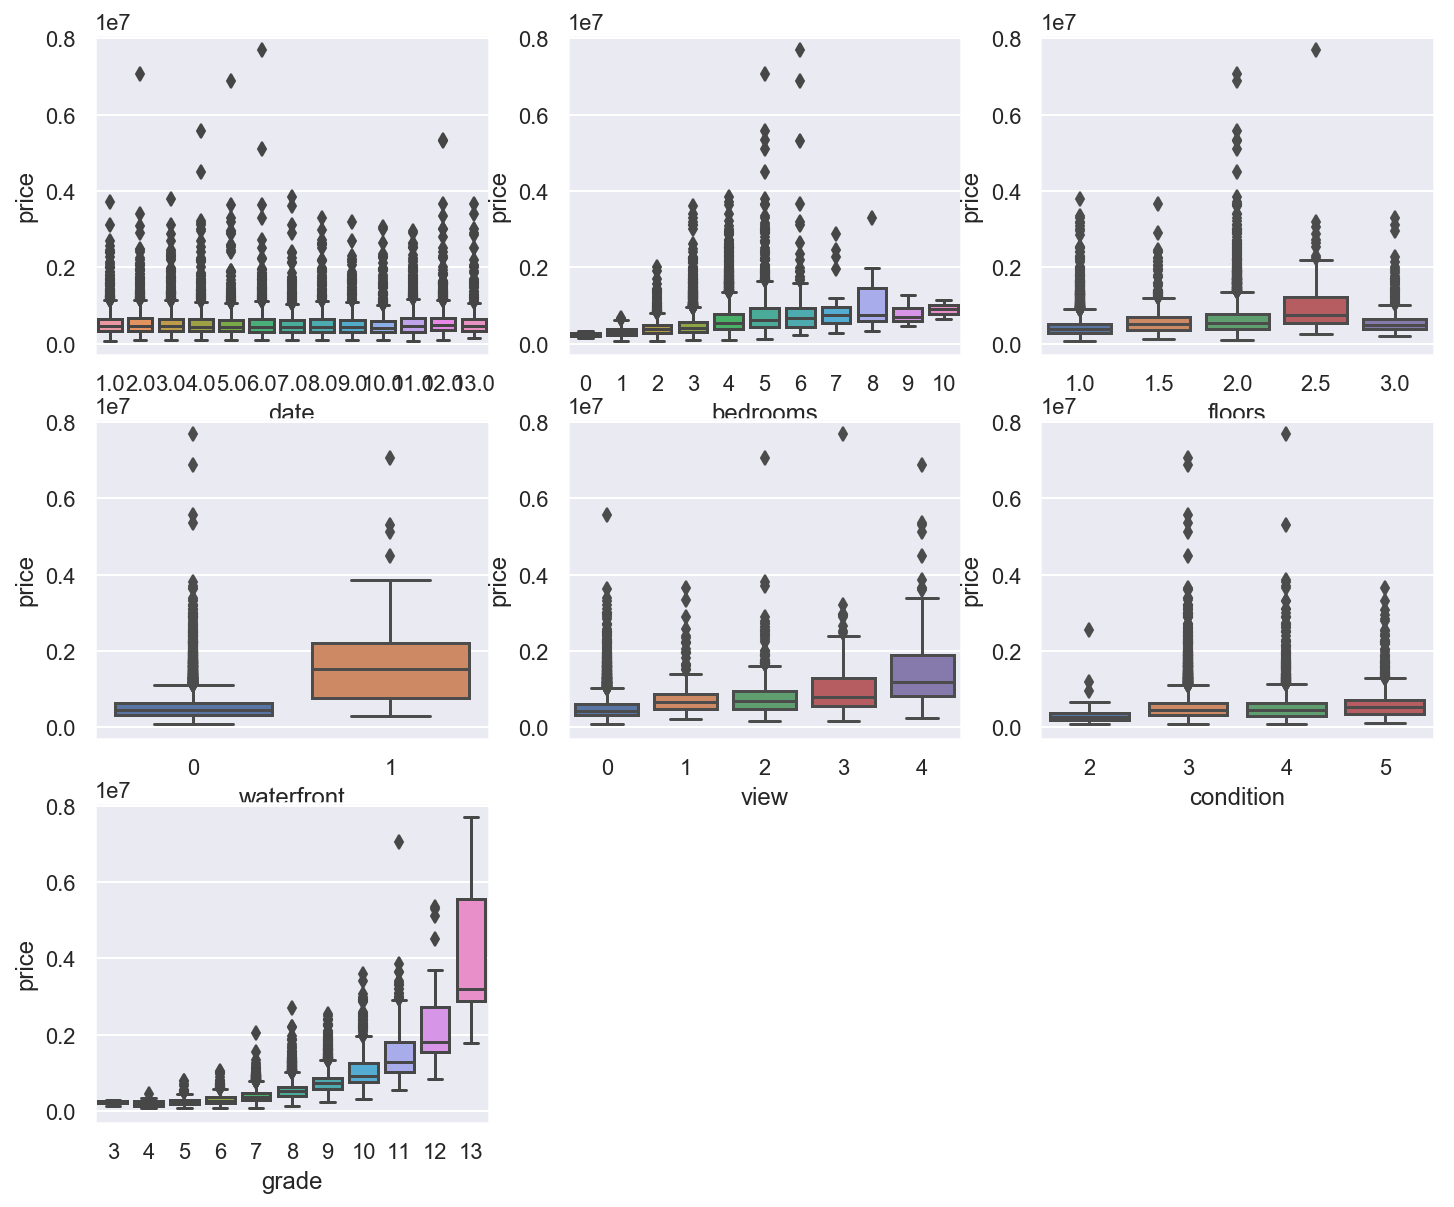

In [101]:
features_Boxplot(house5_1[0], 'price')

### Continuous variables 분포가 치우친 것들 정규화 :  features vs Frequnecy

In [102]:
house6 = []
for i in range(len(house5_1)):
    house6.append(house5_1[i].copy())

그래프가 3X3행렬로 그려집니다.


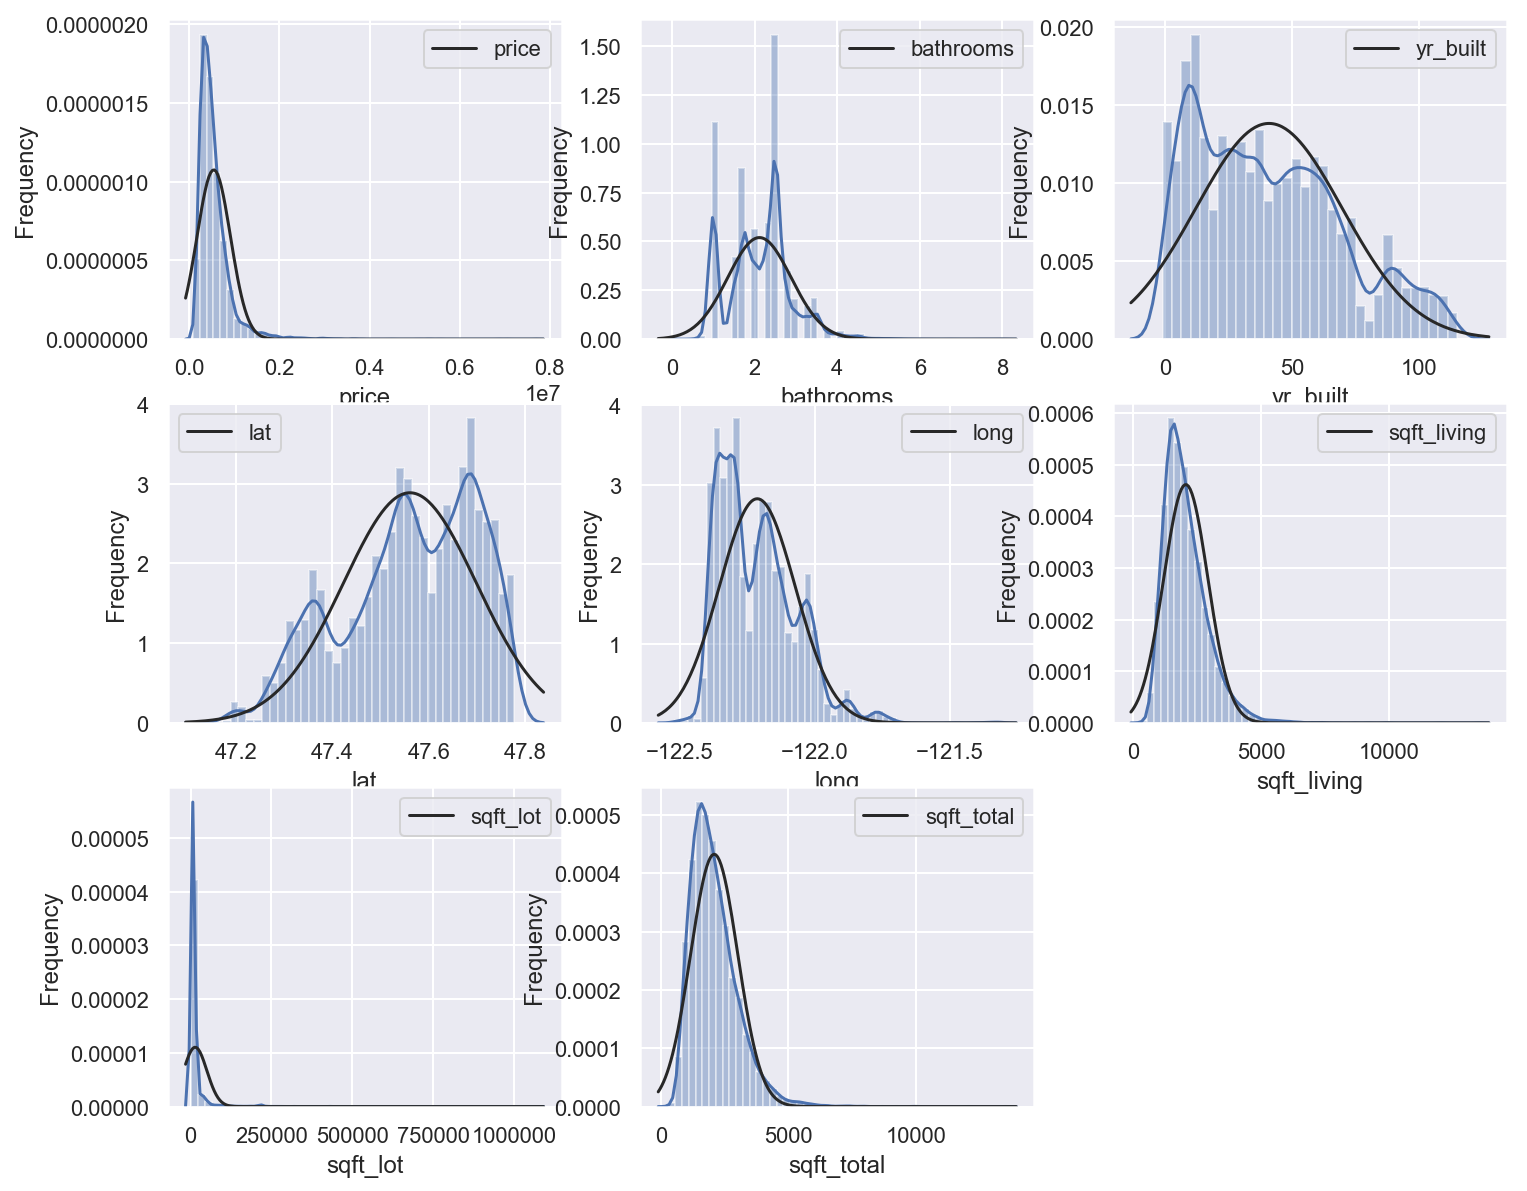

In [103]:
#연속형 변수에 대해서면 빈도 그래프 그려보기
features_vs_frequency(house6[0],True)

### skewness를 기준으로 치우침있는 연속형 features 확인

In [104]:
check_skew(house6[0],column_list_=True, print_col_=False, skewness=1.5) #원래는 1.5가 통상적 기준

Columns ['price', 'bathrooms', 'yr_built', 'lat', 'long', 'sqft_living', 'sqft_lot', 'sqft_total']에서 
 skewness가 1.5보다 높은 columns은 ['price', 'sqft_living', 'sqft_lot']이다.



In [105]:
check_skew(house6[0],column_list_=True, print_col_=False, skewness=0.5) #원래는 1.5가 통상적 기준

Columns ['price', 'bathrooms', 'yr_built', 'lat', 'long', 'sqft_living', 'sqft_lot', 'sqft_total']에서 
 skewness가 0.5보다 높은 columns은 ['price', 'bathrooms', 'yr_built', 'long', 'sqft_living', 'sqft_lot', 'sqft_total']이다.



### 예를 들어, price의 치우친 분포를 log scale로 바꿔서 바로 잡는 것

Skewness: 4.290252


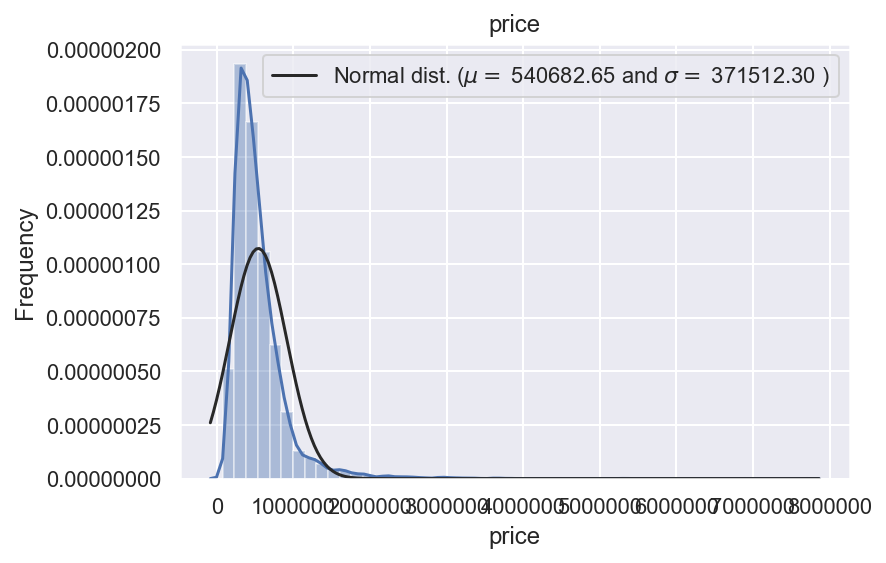

In [106]:
'''
- price의 의 분포도를 살펴보면 아래와 같이 왼쪽으로 치우쳐져있다.
- 치우친 정도가 4.29로 1.5보다 훨씬 크다. 매우 치우쳐져있음.
'''
one_feature_vs_freqency(house6[0],'price')

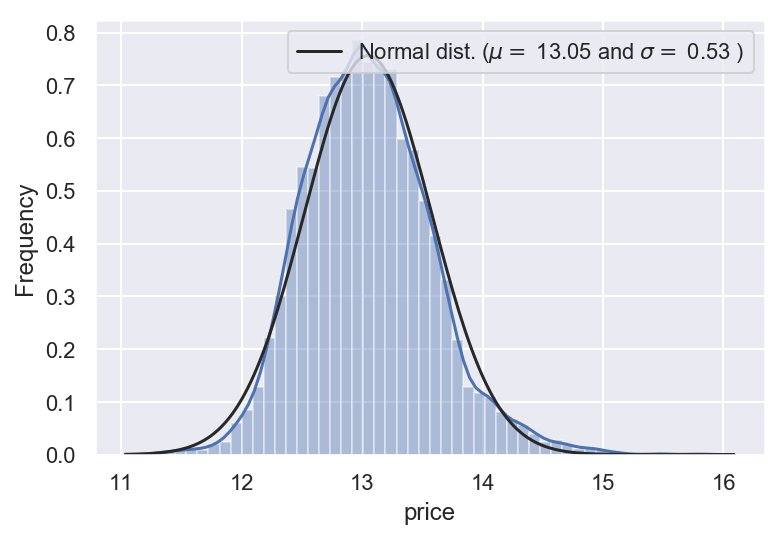

In [107]:
'''
아래와 같이 log로 변환하여 분포를 정규분포화되는 것을 확인한다.
'''
#df = house6[0]; col_str = 'price'; x = df[col_str];
test_for_transf(house6[0], 'price' ,['log(x)'] )

In [108]:
'''
이제 'price' 열의 log 값을 변환해준다.
이 경우 house6[1]은 price정보가 없기 때문에 house6[0]만 변환해준다.
'''
house6[0]['price'] = np.log(house6[0]['price']) 

### 나머지 치우쳐져있는 변수들의 분포 바로잡기

In [109]:
check_skew(house6[0],column_list_ = True, skewness = 0.1, print_col_=False)

Columns ['price', 'bathrooms', 'yr_built', 'lat', 'long', 'sqft_living', 'sqft_lot', 'sqft_total']에서 
 skewness가 0.1보다 높은 columns은 ['price', 'bathrooms', 'yr_built', 'lat', 'long', 'sqft_living', 'sqft_lot', 'sqft_total']이다.



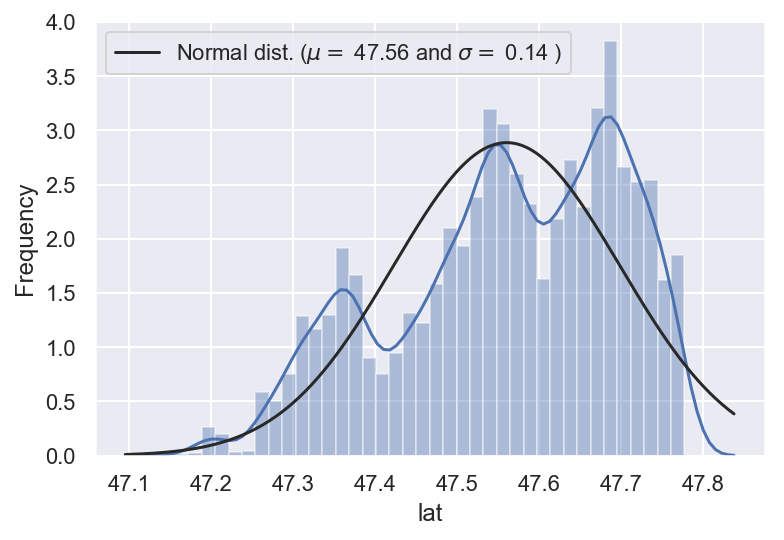

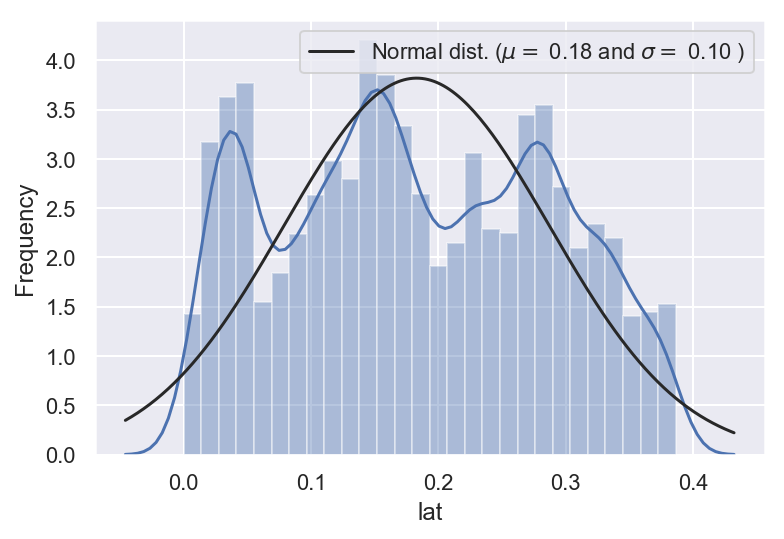

In [110]:
'''
원하는 변수 넣고 원하는 tranf. 함수 넣고 확인하기
'''
xmin = house6[0]['lat'].min() # tranf하고 싶은 함수에 min값이 필요하면 이렇게 정의해서 사용.
test_for_transf(house6[0], 'lat' ,['x', lambda x: (x-xmin)**(2)] )

## 치우침 있는 변수들 tranformation 하기

In [111]:
house7 = []
for i in range(len(house6)):
    house7.append(house6[i].copy())

In [112]:
convert_target = house7  # train + test set인 list입력
original_date = house6[0] # train set의 min, max의 기준이 될 data set

# rescaling
h_long_max = original_date['long'].max()
h_long_min = original_date['long'].min()
h_lat_min = original_date['lat'].min()
h_built_min = original_date['yr_built'].min()

for i in range(len(house6)):
    convert_target[i]['sqft_living'] = np.log(convert_target[i]['sqft_living'])
    convert_target[i]['sqft_total'] = np.log(convert_target[i]['sqft_total'])
    convert_target[i]['sqft_lot'] = np.log(convert_target[i]['sqft_lot'])
    convert_target[i]['long'] = (convert_target[i]['long'] - h_long_min)**(2/3)
    convert_target[i]['lat'] = (convert_target[i]['lat'] - h_lat_min)**2
    convert_target[i]['yr_built'] = (convert_target[i]['yr_built']-h_built_min)**(2/3)
#    convert_target[i]['bathrooms'] = np.log(1 + convert_target[i]['bathrooms'])

### !!!이상치 제거!! 
- random forest 에서는 제거 안하는게 더 정확도 높음
- what about SVM or LR?

In [113]:
house7_1 = []
for i in range(len(house7)):
    house7_1.append(house7[i].copy())

그래프가 3X3행렬로 그려집니다.


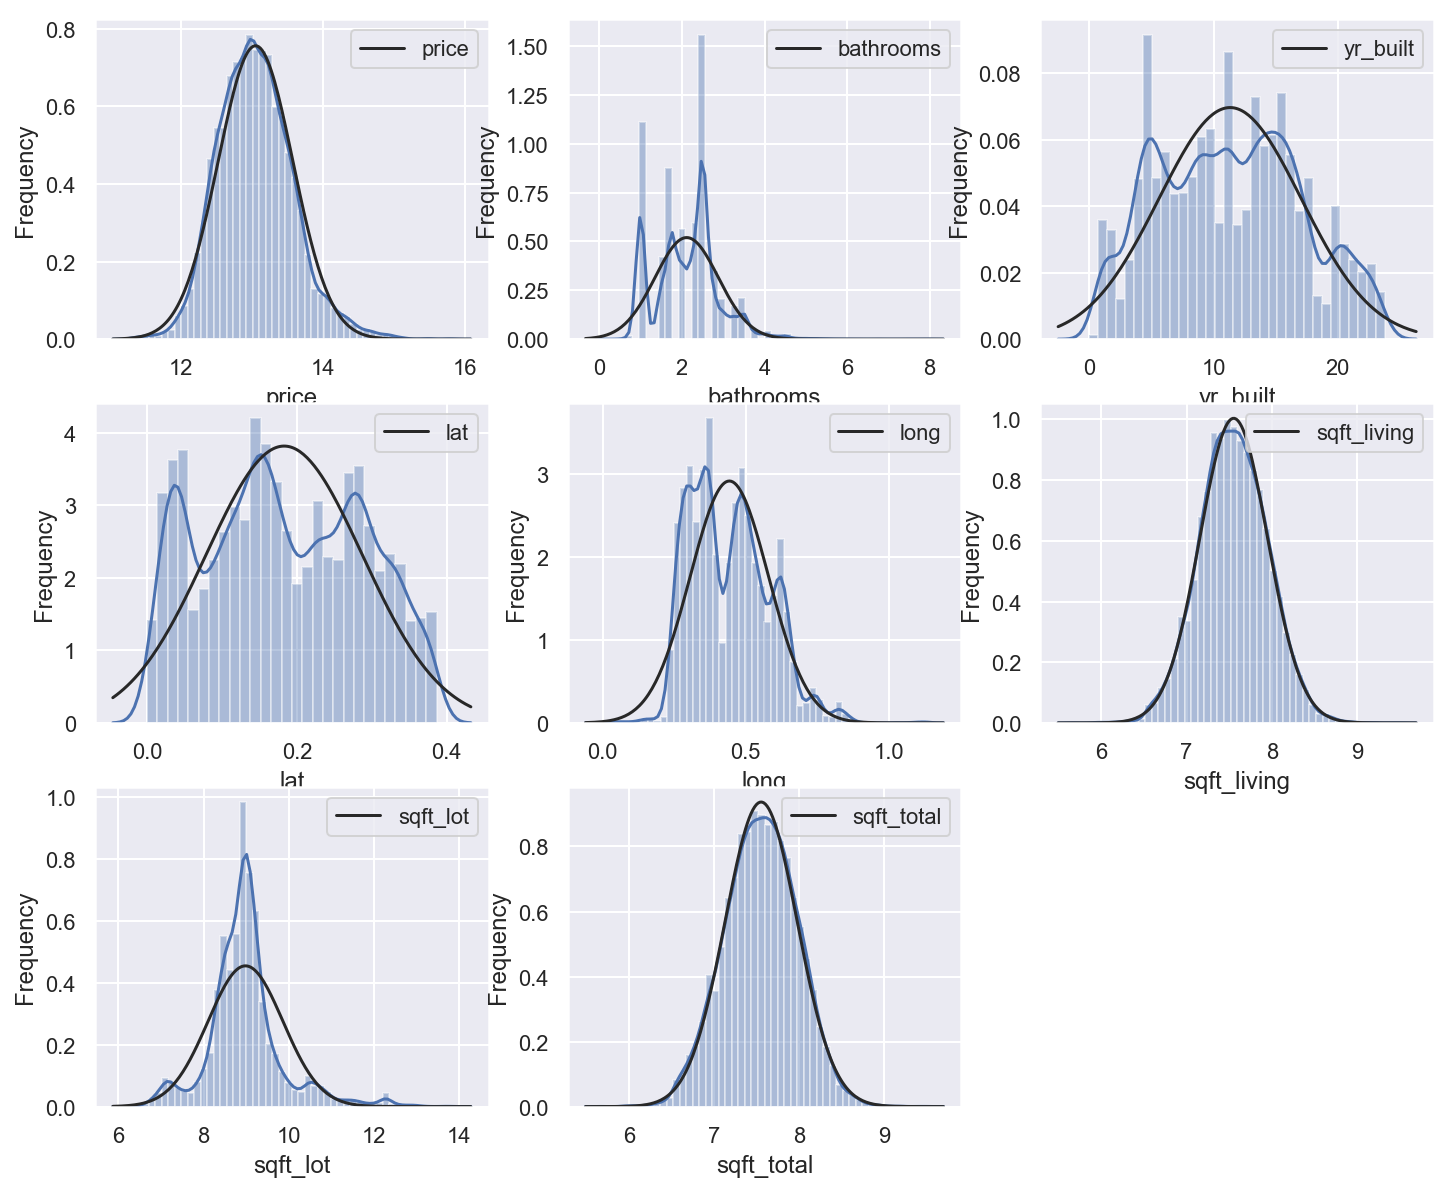

In [114]:
features_vs_frequency(house7_1[0],True)

In [116]:
# from scipy.stats import skew
# skew(house7_1[0]['yr_renovated'])

In [117]:
# Remove_outliers(house7_1[0].drop(columns = ['yr_renovated']), dropna_inplace=True, criterion_Q1=0.15, criterion_Q3=0.85)
# # yr_renovated가 연속변수 임에도 너무 치우쳐져있다.

In [118]:
# # yr_renovated 제외한 것들 대상으로 이상치 제거
# col_target_ = categ_or_contin(house7_1[0].drop(columns=['yr_renovated']),15,print_col=False) # yr_renovated 제외한 것들
# Remove_outliers(house7_1[0], col_target=col_target_, dropna_inplace=True, criterion_Q1=0.15, criterion_Q3=0.85)
# # yr_renovated가 너무 치우쳐져있다.

- **이상치 제거했는 데 뭐가 좋은게 없는것 같아 그래서 일단 스킵**

## #. Features vs price 상관계수 

그래프가 4X4행렬로 그려집니다.


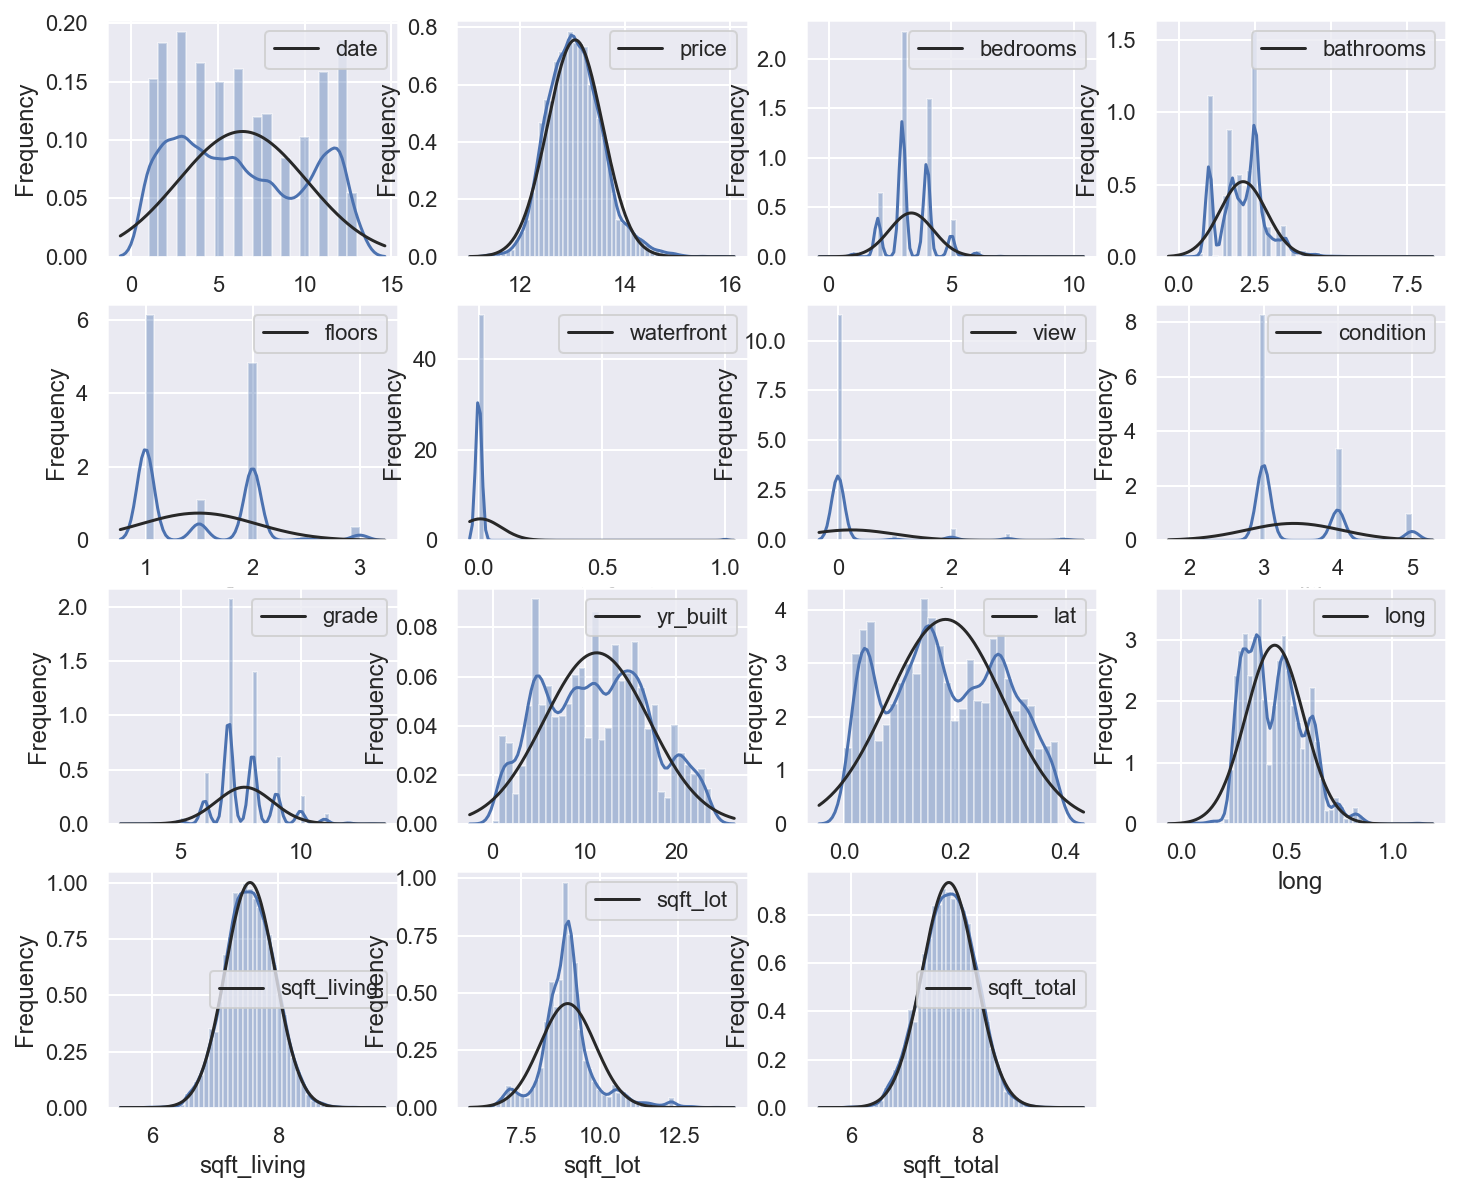

In [119]:
# rescale 처리 후 전체 분포도 
features_vs_frequency(house7[0])

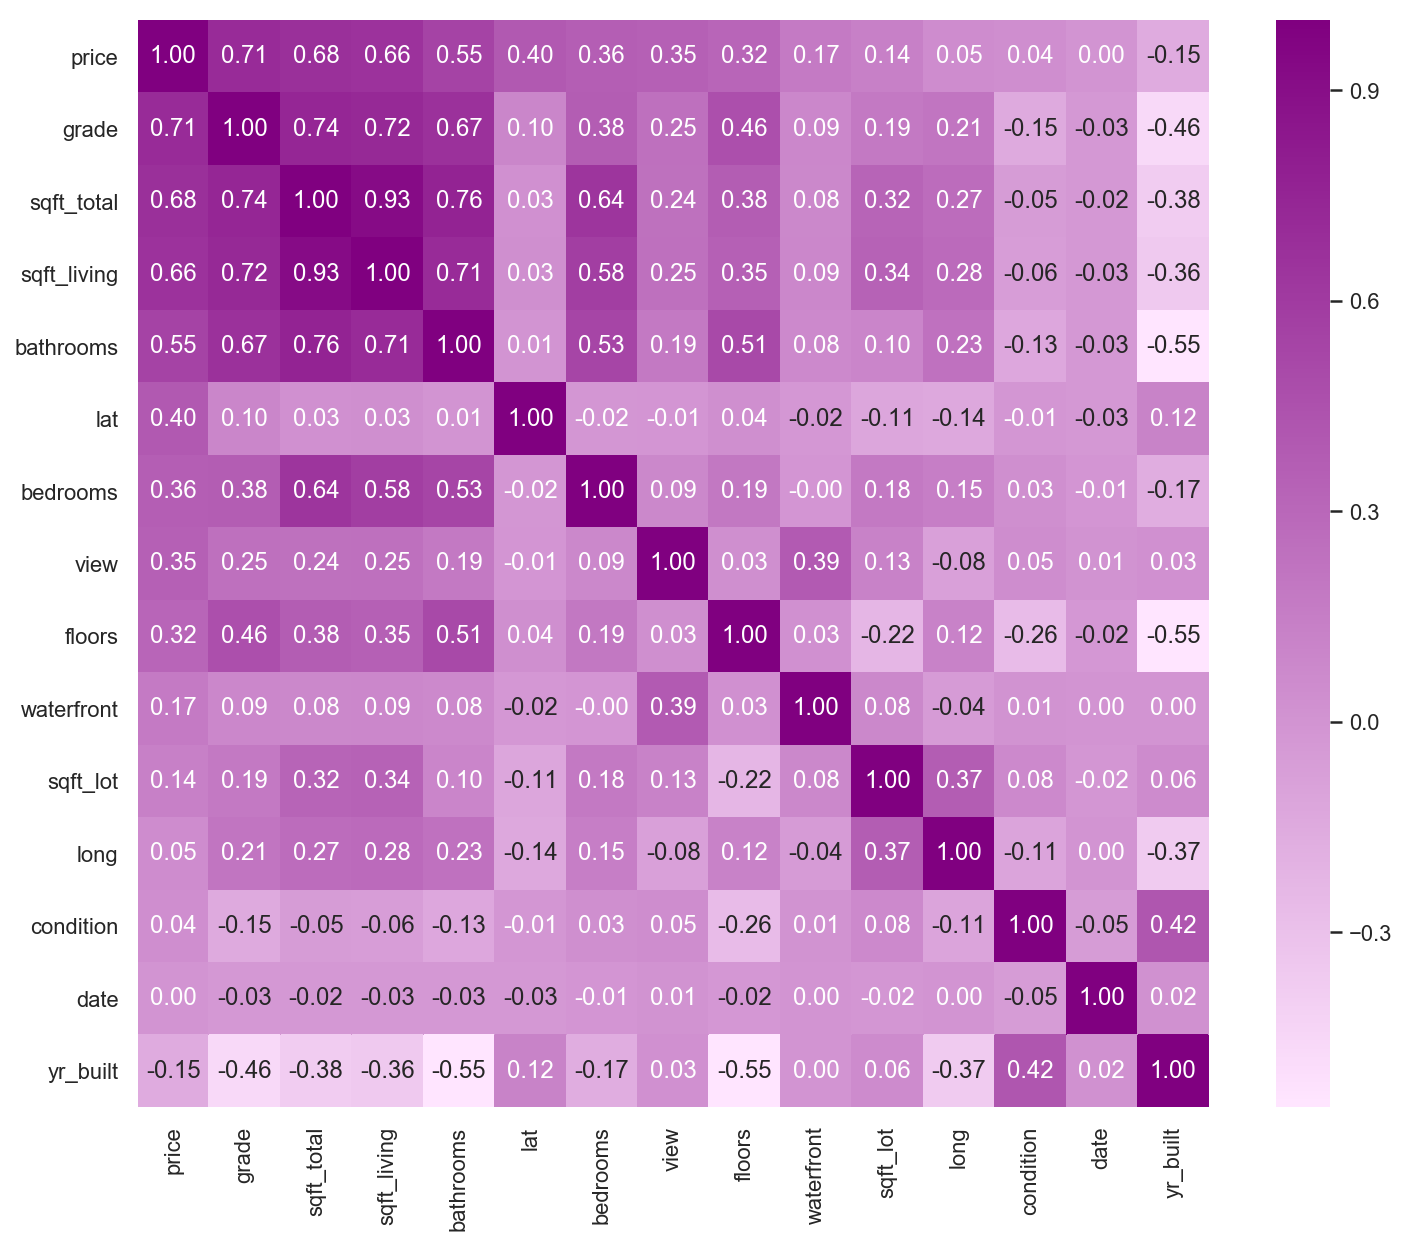

In [120]:
#corr_heatmap(house3[0],'price',figsize_tuple=(6,5))
corr_heatmap(house7[0],'price',figsize_tuple=(12,10))

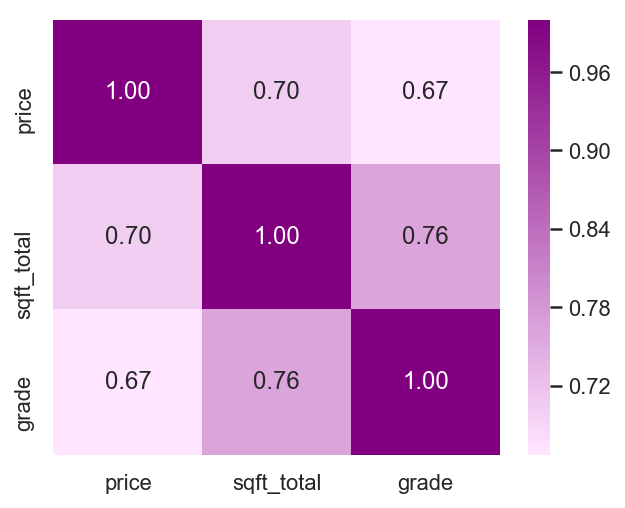

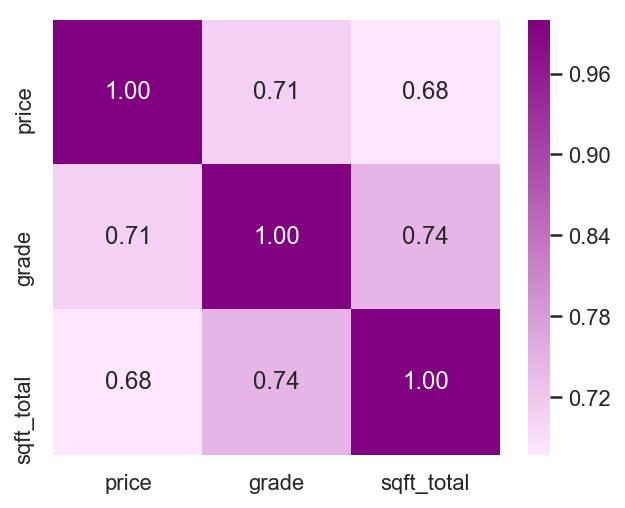

In [121]:
'''
house3에 비해서 전처리가 끝난 house7의 상관관게가 좀더 증가한것을 볼 수 있다.
'''
corr_heatmap(house3[0],'price',['price', 'grade', 'sqft_total'],figsize_tuple=(5,4))
corr_heatmap(house7[0],'price',['price', 'grade', 'sqft_total'],figsize_tuple=(5,4))

그래프가 3X3행렬로 그려집니다.


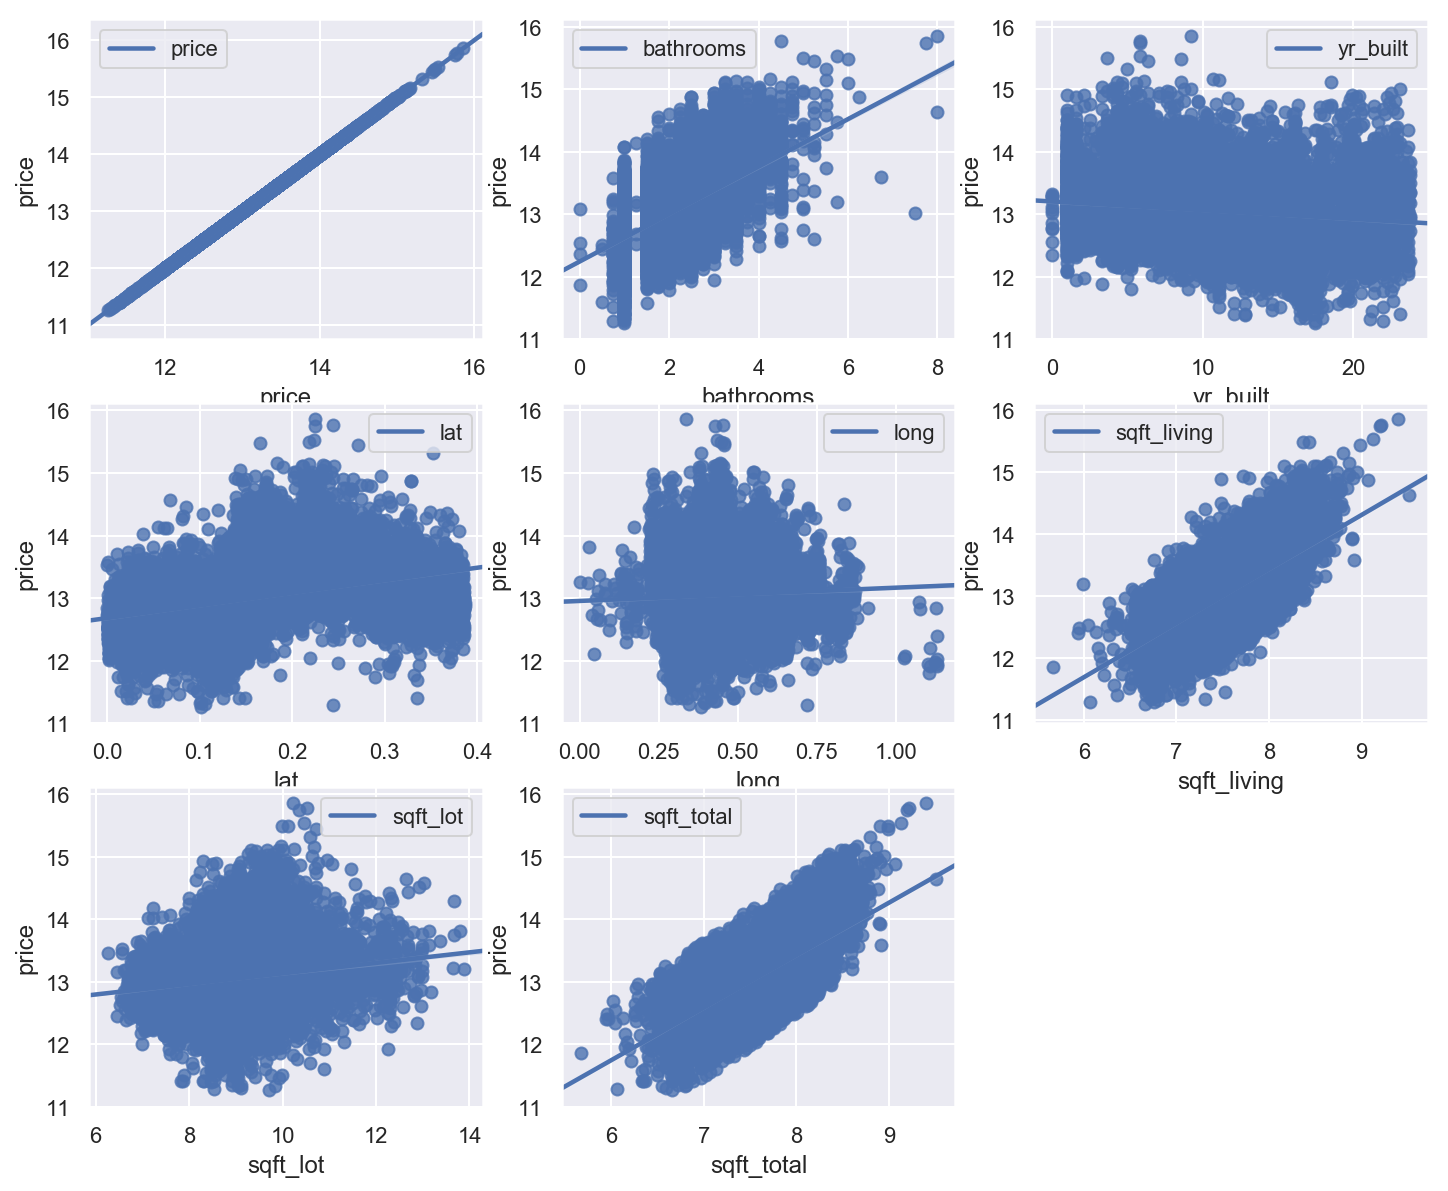

In [122]:
features_vs_label(house7[0],'price',True)

그래프가 3X3행렬로 그려집니다.


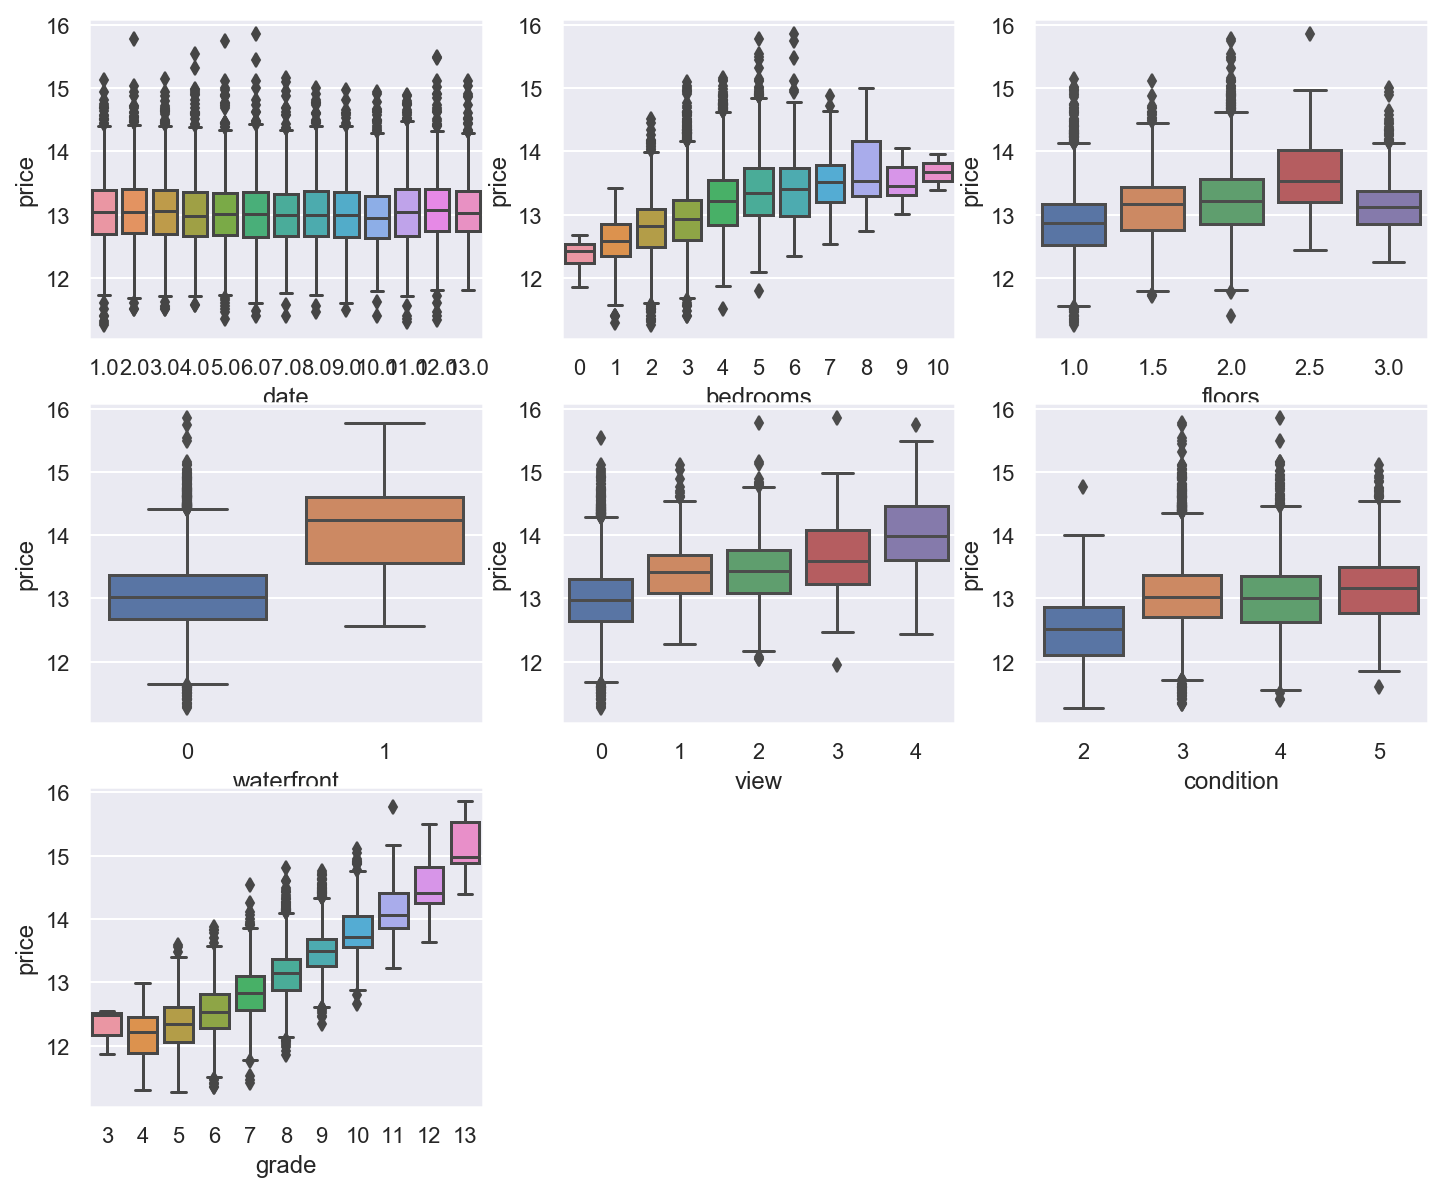

In [123]:
features_Boxplot(house7[0],'price')

### #. price와 yr_built, yr_renovated의 관계
- 미국인들은 완전 새집 보다 적당히 antique한 집을 선호할 수 있다는 의견을 받음
- 모든 집들을 연식에 따른 분포를 보면 당연히 스펙트럼이 고르게 퍼져있을 것임.(이미 앞에서 상관관계가 0.1인 점에서 알 수 있음)
- 따라서 비슷한 레벨의 집들을 두고 연식에 따른 가격분포를 살펴보자.
- 상관관계 1,2위 변수(grade, sqft_total)를 통제해서 비슷한 레벨로 맞추어줄것임.

**1. 비슷한 sqft_total의 집들을 대상으로 연식에 따른 가격 분포 조사**
- sqft_total이 5.66~9.51까지 있었음.
- 전부 소숫점 첫째자리에서 반올림해서 비슷한 부지 넓이 가지는 집끼리 categorizing함
- 그리고 주어진 category에서 연식 대비 집값 조사

In [59]:
house7_2 = []
for i in range(len(house7)):
    house7_2.append(house7[i].copy())

In [60]:
house7_2[0]['sqft_total'].describe()

count    15035.000000
mean         7.551787
std          0.425902
min          5.669881
25%          7.265430
50%          7.554859
75%          7.847763
max          9.513404
Name: sqft_total, dtype: float64

In [61]:
house7_2[0]['sqft_total'] = round(house7_2[0]['sqft_total'],0) # sqft_total을 범주형 변수로 수정

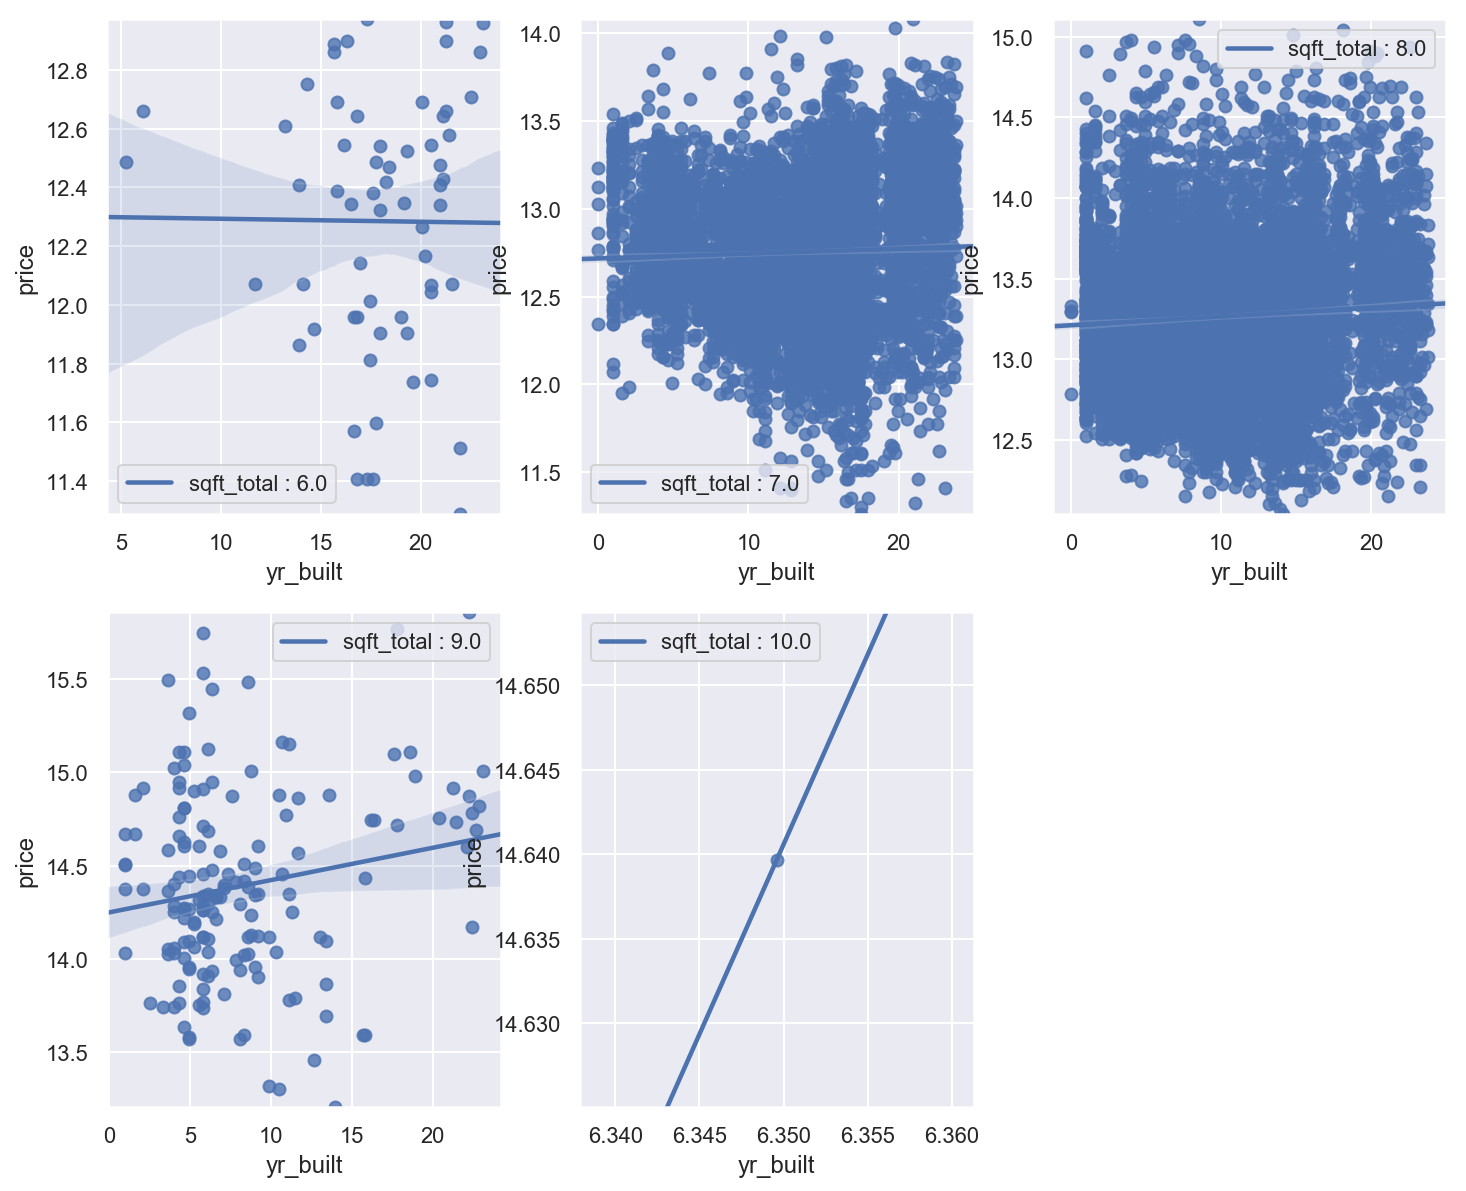

In [62]:
x_vs_y_with_fixed_col(house7_2[0],'yr_built', 'price' ,'sqft_total')

- 총면적이 9에 있는 것들은 새집이(0에 가까울수록 새집) 비싼 경향이 있는데 아무래도 보통은 고르게 분포되어있다.

**2. 같은 grade의 집들을 대상으로 연식에 따른 가격 분포 조사**

In [63]:
house7_2[0]['grade'].describe()

count    15035.000000
mean         7.660725
std          1.179803
min          1.000000
25%          7.000000
50%          7.000000
75%          8.000000
max         13.000000
Name: grade, dtype: float64

- **그래프 옵션에 계수를 봐라**

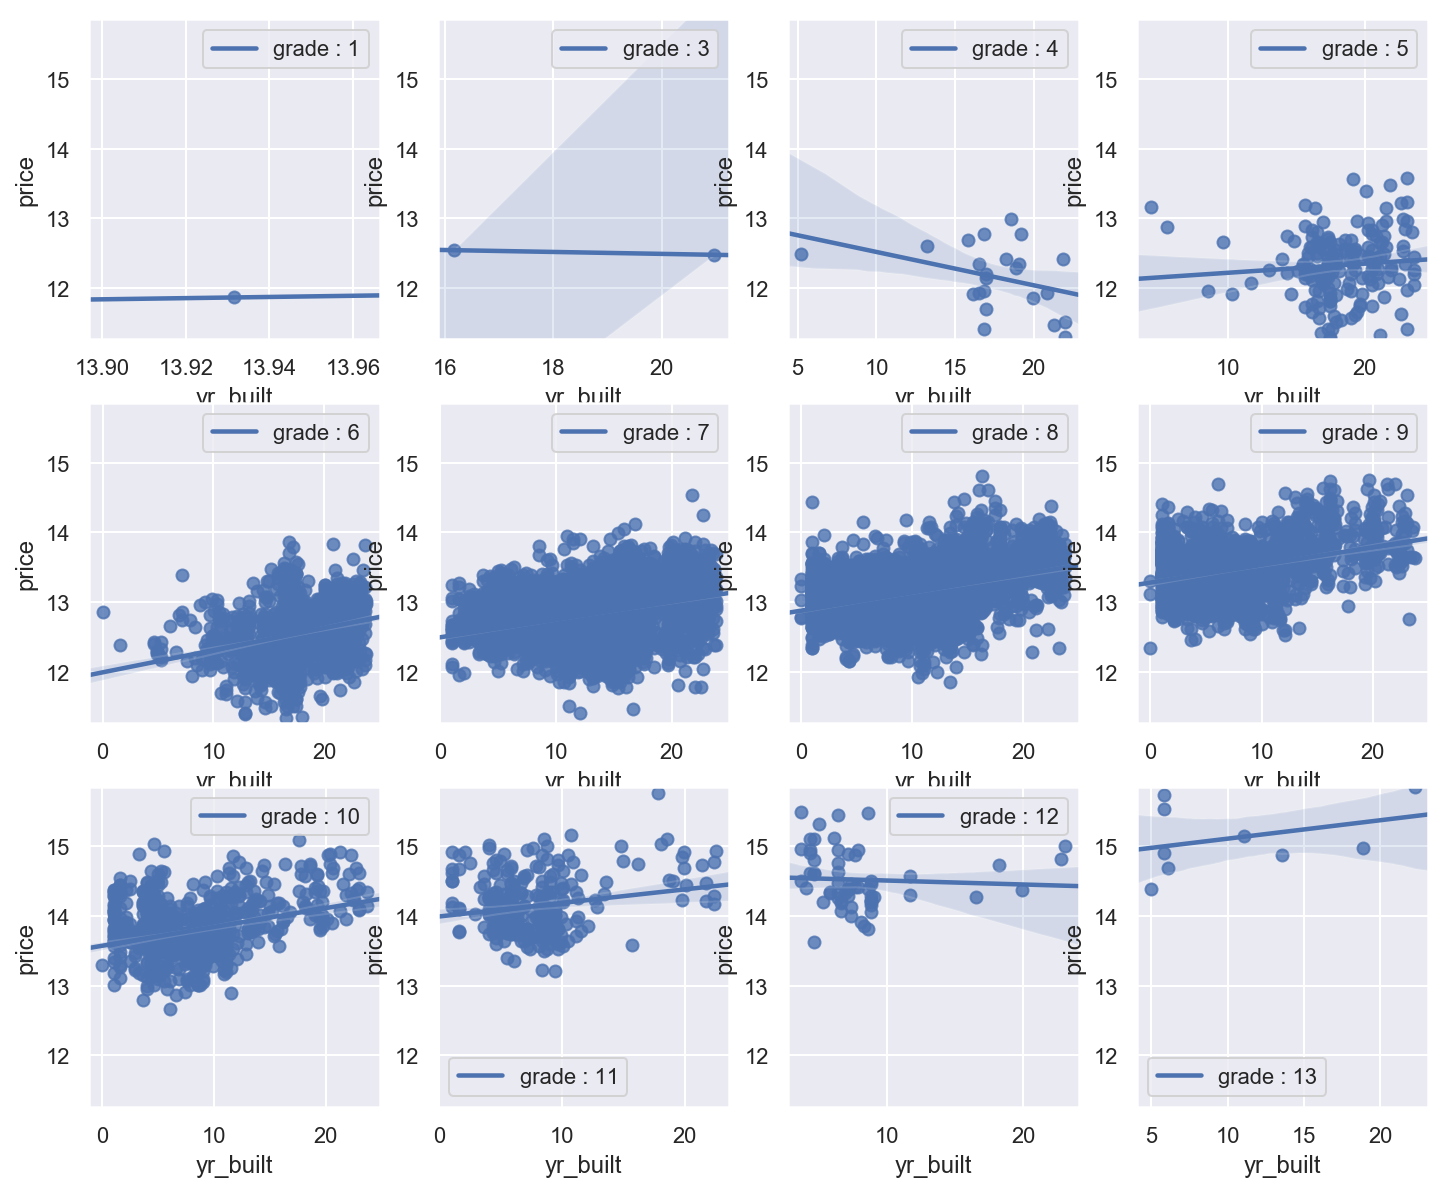

In [54]:
x_vs_y_with_fixed_col(house7_2[0],'yr_built', 'price' ,'grade', house7[0]['price'].min(), house7[0]['price'].max())

/Library/Frameworks/Python.framework/Versions/3.6/lib/python3.6/site-packages/matplotlib/pyplot.py:1479: UserWarning: Attempting to set identical bottom==top results
in singular transformations; automatically expanding.
bottom=11.863582336583399, top=11.863582336583399
  ret = ax.set_ylim(*args, **kwargs)


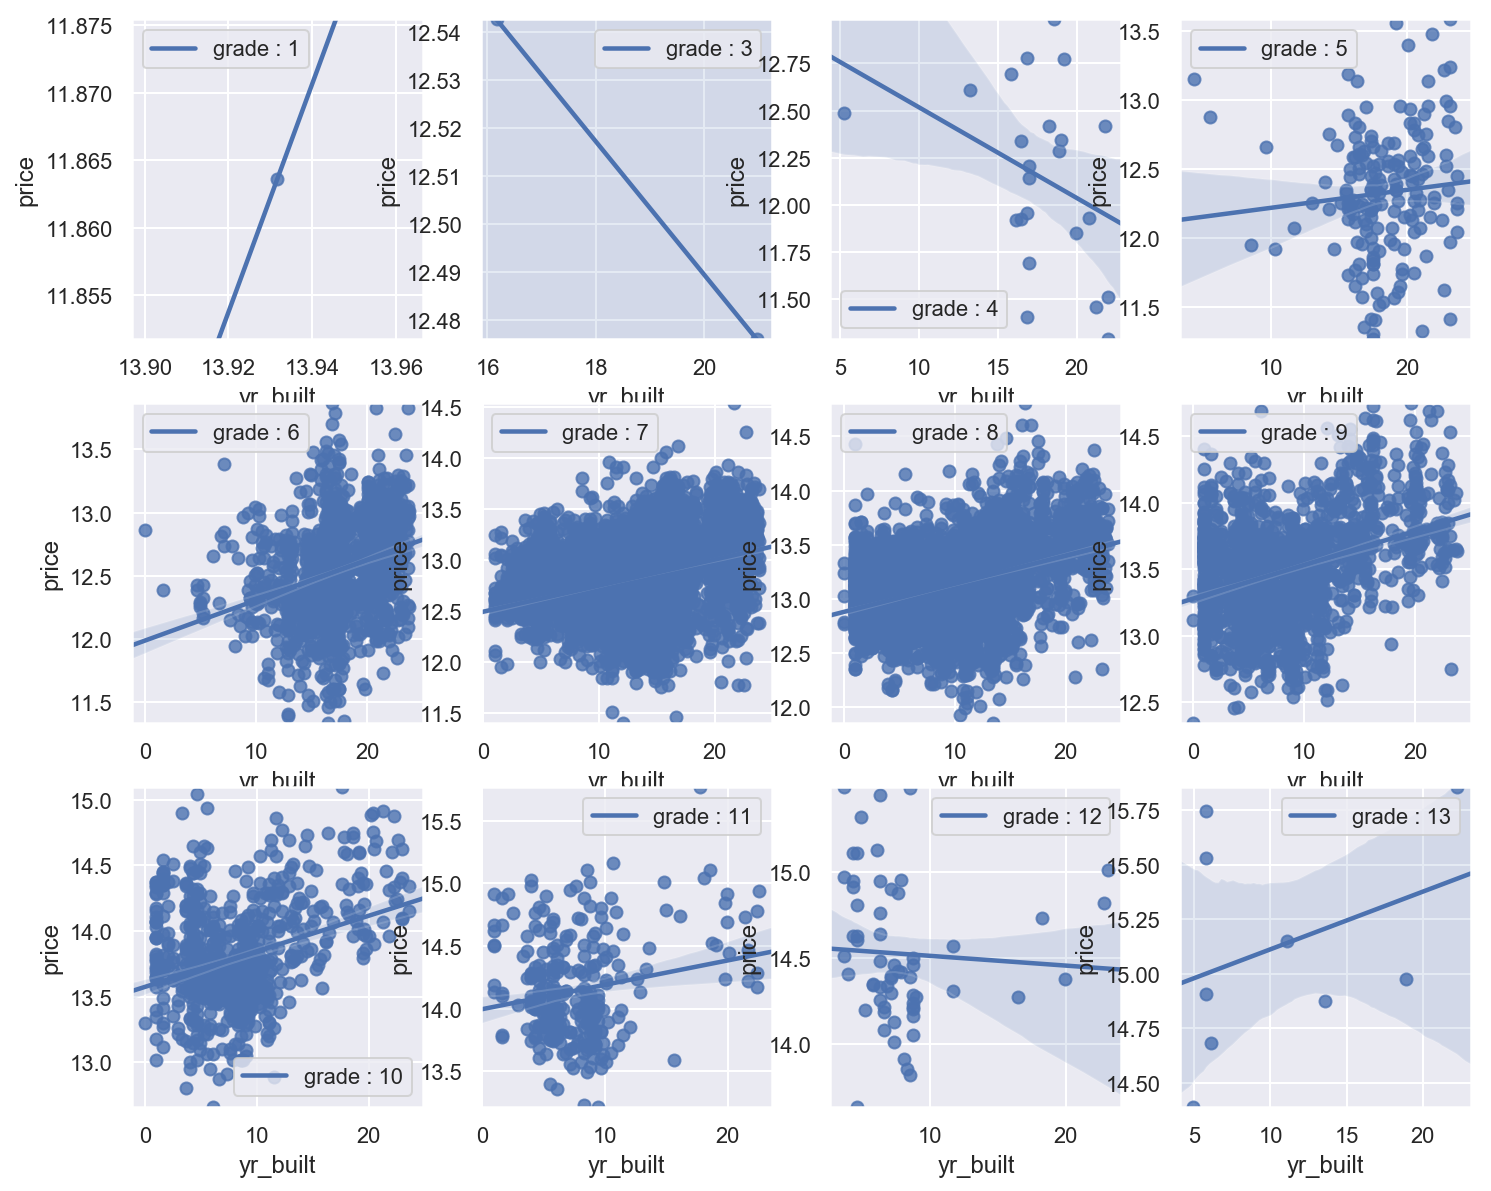

In [55]:
x_vs_y_with_fixed_col(house7_2[0],'yr_built', 'price' ,'grade')

1. grade가 높은 것들에는 새집(yr_built~0)이 많이 분포. grade와 yr_built가 꽤 상관관계가 있음
  1. 1,3,4,5은 옛날집에 너무 편중되어있음.
  1. 11,12,13은 새집에 너무 편중되어있음.
1. 그래도 나름 고른 분포를 보이는 6~10 그리고 11가지도 오래된 집이 좀더 비싼 경향이 있음
1. 상관계수

The correlation between yr_built and price in grade(1) is nan.
The correlation between yr_built and price in grade(3) is -1.0.
The correlation between yr_built and price in grade(4) is -0.36.
The correlation between yr_built and price in grade(5) is 0.09.
The correlation between yr_built and price in grade(6) is 0.29.
The correlation between yr_built and price in grade(7) is 0.35.
The correlation between yr_built and price in grade(8) is 0.39.
The correlation between yr_built and price in grade(9) is 0.36.
The correlation between yr_built and price in grade(10) is 0.33.
The correlation between yr_built and price in grade(11) is 0.2.
The correlation between yr_built and price in grade(12) is -0.06.
The correlation between yr_built and price in grade(13) is 0.35.


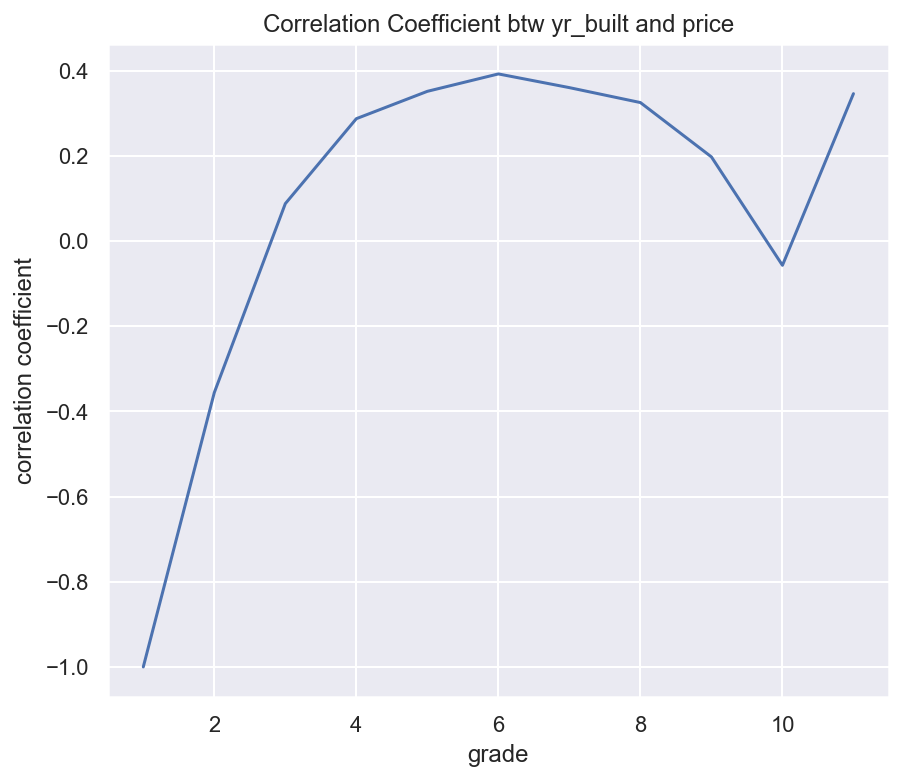

The correlation between yr_built and price in sqft_total(6.0) is -0.01.
The correlation between yr_built and price in sqft_total(7.0) is 0.04.
The correlation between yr_built and price in sqft_total(8.0) is 0.06.
The correlation between yr_built and price in sqft_total(9.0) is 0.18.
The correlation between yr_built and price in sqft_total(10.0) is nan.


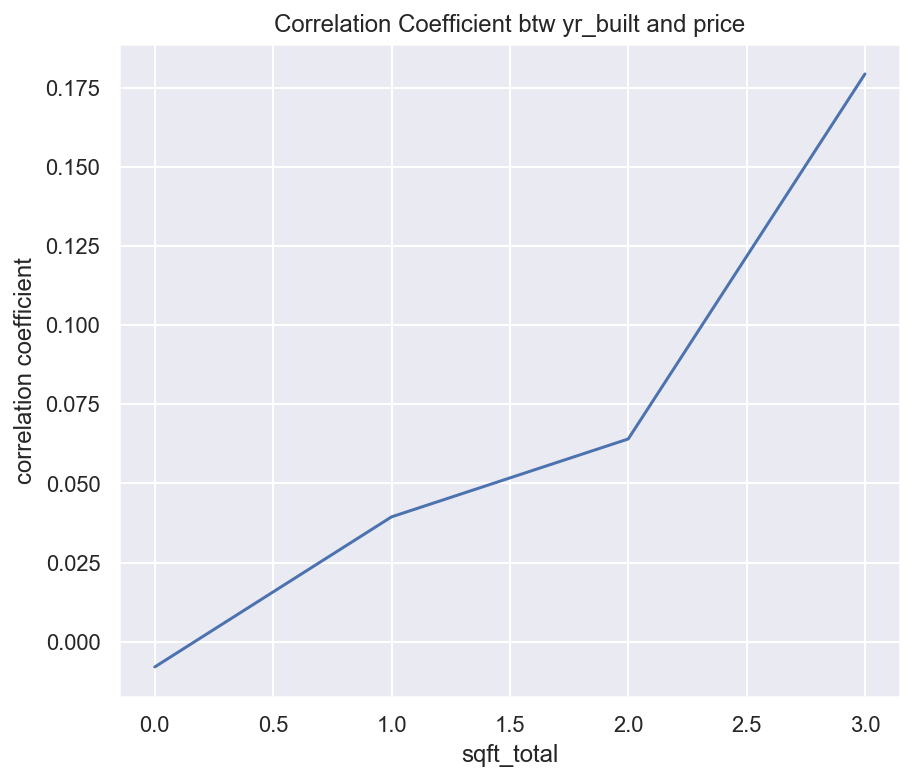

In [113]:
corr_btw_x_y_VS_fixed_col(house7_2[0],'yr_built', 'price', 'grade')
corr_btw_x_y_VS_fixed_col(house7_2[0],'yr_built', 'price', 'sqft_total')

In [112]:
# target = house7_2[0] 
# x_col = 'yr_built'
# y_col = 'price'
# fixed_col = 'grade'
# figsize_tuple=(8, 7); palette_color='purple'; fmt_=".2f"


# category_ls = list(count_category(target,[fixed_col],sort_category=True)['category']) #특정 범주형 변수의 범주 종류 list화
# j=0
# fig = plt.figure(figsize=figsize_tuple)
# row_len, col_len = rowXcol_for_subfig(len(category_ls))

# data = []

# for i in category_ls:
#     h_corr = target[target[fixed_col]==i][[x_col, y_col]].corr(method='pearson')
#     x_y_corr = h_corr.loc[x_col, y_col]
#     print('The correlation between {} and {} in {}({}) is {}.'.format(x_col, y_col, fixed_col, i, round(x_y_corr,2)))
#     data.append(x_y_corr)

# plt.plot(data)
# plt.xlabel(fixed_col)
# plt.ylabel('correlation coefficient')
# plt.title('Correlation Coefficient btw {} and {}'.format(x_col, y_col))
# plt.show()     
        


## 이 결론을 바탕으로 더 할 수 있는 것은?
- 새로운 feature을 넣을 것이 있을까?

In [ ]:
# h4_col = list(h_corr1.columns)
# sns.pairplot(house4[0][h4_col], diag_kind = 'auto') 
# #diag_kind : {‘auto’, ‘hist’, ‘kde’}, hue="species" kind="reg"
# plt.show()

# Model Training

## 0. 무관한 변수들을 drop

In [124]:
# 무관한 변수들을 drop한다

# 연속형 변수만.
house8_cont = []

for i in range(len(house7)):
    house8_cont.append(house7[i][categ_or_contin(house7[i],print_col=False)])

# categorical 변수만..
house8_cat = []

cat_or_cont = categ_or_contin(house7[0], cat_or_cont = False,print_col=False)

house8_cat.append(house7[0][np.union1d(cat_or_cont,['price'])])
house8_cat.append(house7[1][cat_or_cont])


#house8[0].head()

# 전체 변수에 대해..
house8 = []

for i in range(len(house7)):
    house8.append(house7[i])#.drop(columns=['yr_renovated']))


# house8.append(house7[0][['price', 'grade','sqft_total','sqft_living','bathrooms','lat']])#[categ_or_contin(house7[i],print_col=False)])#.drop(columns=['yr_renovated']))
# house8.append(house7[1][['grade','sqft_total','sqft_living','bathrooms','lat']])
# house8[0].head()



## 데이터 셋 설정

In [160]:
house_model = house8 # 이거만 변경해주면 됨

cont_var = categ_or_contin(house_model[0].drop(columns=['price']),cat_or_cont=True, print_col=False)
categ_var = categ_or_contin(house_model[0].drop(columns=['price']),cat_or_cont=False, print_col=False)

# 훈련 셋과 평가 셋으로 나누기
Train_X, Test_X, Train_Y, Test_Y \
= train_test_split(house_model[0].drop(columns=['price']), house_model[0]['price'], \
                   test_size=0.3)

Train_X_cont = Train_X[cont_var]
Train_X_categ = Train_X[categ_var]

Test_X_cont = Test_X[cont_var]
Test_X_categ = Test_X[categ_var]

# Test set 정의
submit_X = house_model[1]   # 전처리된 test set

submit_X_cont = submit_X[cont_var]
submit_X_categ = submit_X[categ_var]

# 유사 정답 세트 가져오기
sample = pd.read_csv("dataset/test_sample.csv")
submit_Y = sample['price']  # 정답 sample로부터 label가져오기, 정규화 안시킴

In [162]:
len(Train_X_categ), len(Train_X_cont), len(Train_Y)
len(Test_X_categ), len(Test_X_cont), len(Test_Y)

(4511, 4511, 4511)

# 1. Linear Regression

In [149]:
# house_model = house8_cont # 이거만 변경해주면 됨

# # 훈련 셋과 평가 셋으로 나누기
# Train_X, Test_X, Train_Y, Test_Y \
# = train_test_split(house_model[0].drop(columns=['price']), house_model[0]['price'], \
#                    test_size=0.3)
# # Test set 정의
# submit_X = house_model[1]   # 전처리된 test set
# # 유사 정답 세트 가져오기
# sample = pd.read_csv("dataset/test_sample.csv")
# submit_Y = sample['price']  # 정답 sample로부터 label가져오기, 정규화 안시킴

In [154]:
from sklearn import datasets, linear_model
from sklearn.metrics import mean_squared_error, r2_score

In [163]:
# Create linear regression object
regr = linear_model.LinearRegression()

# Train the model using the training sets
regr.fit(Train_X_cont, Train_Y)

'''
Test_Y에 예측
'''

# Make predictions using the testing set
y_pred_test = regr.predict(Test_X_cont)

# The coefficients
print('Coefficients: \n', regr.coef_)
# The mean squared error
print("root Mean squared error: %.2f"
      % rmse(np.exp(Test_Y), np.exp(y_pred_test))) 

print('accuracy: %.2f' % round(regr.score(Test_X_cont, Test_Y) * 100, 2))

'''
competition set 예측
'''

# Make predictions using the testing set
y_pred = np.exp(regr.predict(submit_X_cont))

# The coefficients
print('Coefficients: \n', regr.coef_)
# The mean squared error
print("root Mean squared error: %.2f"
      % rmse(submit_Y, y_pred)) #mean_squared_error(submit_Y, y_pred)
# Explained variance score: 1 is perfect prediction
print('Variance score: %.2f' % r2_score(submit_Y, y_pred))

print('accuracy: %.2f' % round(regr.score(submit_X_cont, np.log(submit_Y)) * 100, 2))

Coefficients: 
 [ 0.104936    0.01019767  1.78292419 -0.21752777  0.30304137 -0.01731703
  0.50186598]
root Mean squared error: 264596.98
accuracy: 62.93
Coefficients: 
 [ 0.104936    0.01019767  1.78292419 -0.21752777  0.30304137 -0.01731703
  0.50186598]
root Mean squared error: 244808.64
Variance score: 0.53
accuracy: 62.16


# 3. Random Forest

In [164]:
# house_model = house8_cat # 이거만 변경해주면 됨

# # 훈련 셋과 평가 셋으로 나누기
# Train_X, Test_X, Train_Y, Test_Y \
# = train_test_split(house_model[0].drop(columns=['price']), house_model[0]['price'], \
#                    test_size=0.3)
# # Test set 정의
# submit_X = house_model[1]   # 전처리된 test set
# # 유사 정답 세트 가져오기
# sample = pd.read_csv("dataset/test_sample.csv")
# submit_Y = sample['price']  # 정답 sample로부터 label가져오기, 정규화 안시킴

In [174]:
#random_forest 훈련
print("Train a Random Forest model")
random_forest = RandomForestRegressor(n_estimators= 120, min_samples_leaf= 1, max_depth= 20,random_state=42) #n_estimators=200)#, random_state=2)
random_forest.fit(Train_X_categ, Train_Y)

'''
Test_Y에 예측
'''

#예측
y_pred_forest_test = random_forest.predict(Test_X_categ) #Train_Y의 price가 log scale임

# root mean squared error
rmse_random_forest = rmse(np.exp(y_pred_forest_test), np.exp(Test_Y))
# accuracy
acc_random_forest = round(random_forest.score(Test_X_categ, Test_Y) * 100, 2)
print(rmse_random_forest, acc_random_forest)


'''
competition set 예측
'''

#예측
y_pred_forest = np.exp(random_forest.predict(submit_X_categ)) #Train_Y의 price가 log scale임

# id + price dataframe 만들기
result_forest = pd.concat([pd.Series(house_test['id']), pd.Series(y_pred_forest, \
                                                           name = 'price')],axis=1)
# root mean squared error
rmse_random_forest = rmse(result_forest['price'], sample['price'])
# accuracy
acc_random_forest = round(random_forest.score(submit_X_categ, np.log(submit_Y)) * 100, 2)
print(rmse_random_forest, acc_random_forest)




Train a Random Forest model
249334.39148181002 52.64
238397.54207976905 51.34


## New predict = w1*Linear Regression+w2*Random Forest

In [186]:
price_desc = pd.DataFrame(Test_Y).describe()
LR_desc = pd.DataFrame(y_pred_test).rename(columns = {0:'LR'}).describe()
RF_desc = pd.DataFrame(y_pred_forest_test).rename(columns = {0:'RF'}).describe()

In [187]:
pd.concat([price_desc, LR_desc,RF_desc],axis=1)

price           LR           RF
count  4511.000000  4511.000000  4511.000000
mean     13.050731    13.042176    13.049390
std       0.528619     0.418156     0.419223
min      11.326596    11.179737    11.626983
25%      12.685358    12.759395    12.753483
50%      13.017003    13.033023    12.987086
75%      13.377006    13.333749    13.297100
max      15.770310    15.222084    15.229229

In [263]:
LR = pd.Series(y_pred_test,name = 'LR')
RF = pd.Series(y_pred_forest_test,name = 'RF')
sol = pd.Series(Test_Y).reset_index(drop=True)
aa = pd.concat([sol,LR,RF],axis=1).head()
aa

price         LR         RF
0  12.577636  12.928884  12.965712
1  13.662884  13.481675  13.547478
2  12.858398  12.642673  13.192277
3  12.833347  12.976346  12.657209
4  12.826649  13.052238  13.472363

In [249]:
def ensemble_con_cat(w):
    '''
    w: LR 가중치, 1-w: RF 가중치
    0=< w =<1
    '''
    return w*y_pred_test+(1-w)*y_pred_forest_test

def ensemble_con_cat2(w1,w2):
    '''
    w1: LR 가중치, w2: RF 가중치
    '''
    return (w1*y_pred_test+w2*y_pred_forest_test)

In [256]:
x_rmse = []
y_rmse = []
for w1 in np.linspace(0,1,11):
    #x_rmse.append(w1)
    y_rmse.append(round(rmse(np.exp(ensemble_con_cat2(w1,1-w1)), np.exp(Test_Y)),0))
y_rmse

[249334.0,
 242238.0,
 237607.0,
 235191.0,
 234757.0,
 236097.0,
 239036.0,
 243435.0,
 249197.0,
 256259.0,
 264597.0]

In [206]:
# # train set에서는 잘 맞음
# Y_pred_forest_train = np.exp(random_forest.predict(Train_X))
# # root mean squared error
# rmse_random_forest_train = rmse(Y_pred_forest_train, np.exp(Train_Y))
# # accuracy
# acc_random_forest_train = round(random_forest.score(Train_X, Train_Y) * 100, 2)
# print(rmse_random_forest_train, acc_random_forest_train)

- 문제점 : training error > validation error 즉, overfitting problem이 있는 것 같음.
- 해결 방향 : bootstrapping or ensemble로 해보기

## Random forest optimizing

In [ ]:
# # hyperparameter optimizing
# from sklearn.model_selection import GridSearchCV # Search over specified parameter values for an estimator.
# from sklearn.model_selection import RandomizedSearchCV # Search over specified parameter values for an estimator.
# from sklearn.model_selection import ShuffleSplit # Random permutation cross-validator

# from sklearn.model_selection import train_test_split # import 'train_test_split
# from sklearn.ensemble import RandomForestRegressor # import RandomForestRegressor
# from sklearn.metrics import r2_score, make_scorer, mean_squared_error # import metrics from sklearn
# from time import time

# start = time() # Get start time

# rf_regressor = RandomForestRegressor(random_state=42) #객체화
# cv_sets = ShuffleSplit(random_state = 4) # shuffling our data for cross-validation
# parameters = {'n_estimators':[100, 120, 140], 
#               'min_samples_leaf':[1, 2, 3], 
#               'max_depth':[10,15,20]}
# scorer = make_scorer(r2_score)
# n_iter_search = 10
# grid_obj = RandomizedSearchCV(rf_regressor, 
#                               parameters, 
#                               n_iter = n_iter_search, 
#                               scoring = scorer, 
#                               cv = cv_sets,
#                               random_state= 99)
# grid_fit = grid_obj.fit(Train_X, Train_Y)
# rf_opt = grid_fit.best_estimator_

# end = time() # Get end time
# # Calculate training time
# rf_time = (end-start)/60
# print('It took {0:.2f} minutes for RandomSearchCV to converge to optimised parameters for the RF model'.format(rf_time))

# # Get the estimator best parameters
# print(grid_fit.best_params_)



In [ ]:
# # prediction by the optimized random forest
# rf_opt_preds = rf_opt.predict(submit_X) # RF predictions
# # id + price dataframe 만들기
# result_rf_opt = pd.concat([pd.Series(house_test['id']), pd.Series(rf_opt_preds*h_max, \
#                                                            name = 'price')],axis=1)
# # root mean squared error
# rmse_rf_opt = rmse(result_rf_opt['price'], sample['price'])
# #accuracy
# acc_rf_opt = round(grid_obj.score(submit_X, submit_Y) * 100, 2)
# print(acc_rf_opt, rmse_rf_opt)

# 2. Support vector regression

In [144]:
from sklearn.svm import SVR

In [179]:
svr = SVR(gamma='scale', C=1.0, epsilon=0.2)
svr.fit(Train_X, Train_Y) 
y_pred_svr = np.exp(svr.predict(submit_X))

# The coefficients
print('Coefficients: \n', regr.coef_)
# The mean squared error
print("root Mean squared error: %.2f"
      % rmse(submit_Y, y_pred_svr)) #mean_squared_error(submit_Y, y_pred)
#alccuracy
print('accuracy: %.2f' % round(svr.score(submit_X, np.log(submit_Y)) * 100, 2))

Coefficients: 
 [ 5.01376701e-03 -3.02645590e-02  7.10481016e-02  7.65532914e-02
  3.42640625e-01  7.58255109e-02  5.63929253e-02  1.85784940e-01
  1.99693340e-02 -3.48690678e-04  1.64116569e+00 -7.95583233e-02
  1.25157032e-01  3.01997825e-01]
root Mean squared error: 368065.99
accuracy: -0.25


In [190]:
pd.DataFrame(submit_Y).describe()

price
count  6.468000e+03
mean   5.390806e+05
std    3.576264e+05
min    7.500000e+04
25%    3.218750e+05
50%    4.500000e+05
75%    6.423750e+05
max    4.668000e+06

In [188]:
pd.DataFrame(y_pred_svr).describe()

0
count    6468.000000
mean   451902.831921
std        83.896029
min    451709.841886
25%    451838.320286
50%    451925.366076
75%    451973.564047
max    452028.094988

# 나오는 rmse가 계속 같은걸 보니 여기부터는 데이터 전처리의 문제가 아닌듯. 
# 모델을 바꿔보자
### 시도해볼 아이디어
- 모든 변수를 RF와 LR에 넣고 예측된 예측치의 선형 조합으로 제일 좋은 조합 찾기
- 상관관계가 가장 높은 feature의 조합으로 새로은 feature 만들어보기
    - 또는 grade 같은 명목형인데 상관관계 높은것과, 연속형인데 상관관계 낮은 것의 조합으로 새로운 feature만들기
- 거리 feature 만들기
- 유전 알고리즘으로 feature slection 하기


### 실패 아이디어
- random forest에는 명목형 변수, linear regression에는 연속형 변수를 넣고, 나온 예측치들을 선형 조합하여서 정답과 제일 유사한 조합을 찾아내기.
    - 예를 들어 RF의 예측치는 정답보다 좀 작게 예측되고, LR의 예측치는 정답보다 크게 예측되면 좋은 예측치를 줬을 모델인데,
    - 한모델 안에서도 값이 정답보다 큰것도 있고, 작은것도 있고해서 단순 선형 조합은 무의미.
    - 비선형 조합은?



In [ ]:
# import tensorflow as tf
# tf.set_random_seed(777)  # for reproducibility

# filename_queue = tf.train.string_input_producer(
#     ['data-01-test-score.csv'#,'data-01-test-score.csv', ...이렇게 여러개도 가
#      ], shuffle=False, name='filename_queue')

# #아래는 텍트스파일을 읽을 때 일반적으로 사용할 수 있는 것.
# reader = tf.TextLineReader()  # 파일을 읽어올 리더 지 지정.
# key, value = reader.read(filename_queue) #key와 value에 지정.

# # Default values, in case of empty columns. Also specifies the type of the
# # decoded result.
# record_defaults = [[0.], [0.], [0.], [0.]]
# xy = tf.decode_csv(value, record_defaults=record_defaults)
# #value를 어떻게 이해할 것인가?


# # collect batches of csv in
# train_x_batch, train_y_batch = \
#     tf.train.batch([xy[0:-1], xy[-1:]], batch_size=10)
# #batch가 일종의 펌프 같이 데이터를 축출해오는것. [xy[0:-1], xy[-1:]]를 batch_size=10개씩 불러온다.


# # placeholders for a tensor that will be always fed.
# X = tf.placeholder(tf.float32, shape=[None, 3])
# Y = tf.placeholder(tf.float32, shape=[None, 1])

# W = tf.Variable(tf.random_normal([3, 1]), name='weight')
# b = tf.Variable(tf.random_normal([1]), name='bias')

# # Hypothesis
# hypothesis = tf.matmul(X, W) + b

# # Simplified cost/loss function
# cost = tf.reduce_mean(tf.square(hypothesis - Y))

# # Minimize
# optimizer = tf.train.GradientDescentOptimizer(learning_rate=1e-5)
# train = optimizer.minimize(cost)

# # Launch the graph in a session. #통상적으로 이렇게 그냥 쓰임
# sess = tf.Session()
# # Initializes global variables in the graph.
# sess.run(tf.global_variables_initializer())

# # Start populating the filename queue. #통상적으로 이렇게 그냥 쓰임
# coord = tf.train.Coordinator()
# threads = tf.train.start_queue_runners(sess=sess, coord=coord)

# for step in range(2001):
#     x_batch, y_batch = sess.run([train_x_batch, train_y_batch]) #펌프질을 해서 데이터를 가져온다.
#     cost_val, hy_val, _ = sess.run(
#         [cost, hypothesis, train], feed_dict={X: x_batch, Y: y_batch})
#     if step % 10 == 0:
#         print(step, "Cost: ", cost_val, "\nPrediction:\n", hy_val)

# #통상적으로 이렇게 그냥 쓰임
# coord.request_stop()
# coord.join(threads)

# # Ask my score
# print("Your score will be ",
#       sess.run(hypothesis, feed_dict={X: [[100, 70, 101]]}))

# print("Other scores will be ",
#       sess.run(hypothesis, feed_dict={X: [[60, 70, 110], [90, 100, 80]]}))

# '''
# Your score will be  [[185.33531]]
# Other scores will be  [[178.36246]
#  [177.03687]]
# '''


In [21]:
# '''
# 유전 알고리즘
# - 특징 선택 알고리즘으로 생명체의 유전 원리를 활용하여 효율적으로 최적의 특징선택을 골라내는 알고리즘.
# 1. generating_initial_generation
#  - 임의로 해의 갯수(number_of_solutions)와 특징 갯수(number_of_features)를 정해준다.
# 2. solution_evaulation
#  - 해집단의 score을 평가한다.
# 3. top_k_solution_selection
#  - score 상위 k개를 고르고 나머지를 제거한다.
# 4. one_point_crossover
#  - 남아있는 탑랭크 데이터로 제거한만큼 자식데이터를 생성한다.
# 5. flip_bit_muation
#  - 새롭게 생성되는 자식데이터 중 돌연변이를 생성한다.
# 6. 정해진 세대만큼 유전이 완료되면 종료한다.
# '''

# import numpy as np
# from sklearn.model_selection import cross_val_score
# import itertools
# #from sklearn.naive_bayes import *
# #from sklearn.model_selection import train_test_split
# from sklearn.metrics import * 

# def generating_initial_generation(number_of_solutions, number_of_features):
#     return np.random.choice([True, False], (number_of_solutions, number_of_features))


# def solution_evaulation(X, Y, generation, model, metric):
#     score_list = []
#     for solution in generation:
#         score = cross_val_score(model, X.iloc[:, solution], Y, cv=5, scoring = metric).mean() 
#         score_list.append(score)
#     return score_list

# def top_k_solution_selection(solutions, score_list, k):
#     score_list = np.array(score_list)
#     top_k_index = (-score_list).argsort()[:k]
#     selected_solutions = solutions[top_k_index]
#     return selected_solutions

# def one_point_crossover(solution1, solution2):
#     sol_length = len(solution1)
#     point = np.random.choice(range(1, sol_length - 1))
#     new_solution = list(solution1[:point]) + list(solution2[point:])
#     return (np.array(new_solution))

# def flip_bit_muation(solution, prob):
#     for i in range(len(solution)):
#         random_number = np.random.random()
#         if random_number <= prob:
#             solution[i] = 1 - solution[i]
#     return solution

# def genetic_algorithm(df_target, n, k, iter_number, fit_model, label_in_df, metric_scoring, \
#                       mutation_ratio_in_sol=0.2, prob_mutation=0.1):
#     # best score 리셋
#     best_score = 0.00
#     best_feature_set = []

#     # features와 label 구분
#     df = df_target
#     X = df.drop(label_in_df, axis = 1)
#     Y = df[label_in_df]

#     current_generation = generating_initial_generation(number_of_solutions = n, number_of_features = len(X.columns))
    
#     for iter_num in range(1, 1+iter_number): # 유전 알고리즘을 10회 수행
#         print(iter_num, "- interation")
#         # 해 평가 및 최고 해 저장 (best_score_index, best_feature_set)
#         evaluation_result = solution_evaulation(X, Y, current_generation, model = fit_model, metric = metric_scoring)
#         current_best_score = max(evaluation_result) # 현재 세대의 최고 성능 저장
#         if current_best_score > best_score:
#             best_score = current_best_score
#             best_score_index = np.where(evaluation_result == best_score)
#             best_feature_set = current_generation[best_score_index]
    
#         # 상위 k개 해를 선택 및 미래 세대에 추가
#         selected_solutions = top_k_solution_selection(current_generation, evaluation_result, k)
#         future_generation = selected_solutions
        
#         for i in range(n - k): # n-k번을 반복하여 해를 생성
#             p1 = np.random.randint(len(future_generation))  # 임의의 부모 선택
#             p2 = np.random.randint(len(future_generation))    
#             parent_solution_1 = future_generation[p1] # future generation에서 하나를 선택
#             parent_solution_2 = future_generation[p2] # future generation에서 하나를 선택
#             child_solution = one_point_crossover(parent_solution_1, parent_solution_2)
#             future_generation = np.vstack((future_generation, child_solution)) # child solution을 future generation에 추가
    
#         for s in range(len(future_generation)):
#             random_number = np.random.random()
#             if random_number <= mutation_ratio_in_sol: # 비율만큼 해에 대해 돌연변이 연산을 적용
#                 future_generation[s] = flip_bit_muation(future_generation[s], prob = prob_mutation) # 요소에서 돌연변이 비율 0.1
    
#     selected_features = X.columns[np.where(best_feature_set[0])[0]] # np.where : array의 성분 중 True인 것의 index 만 골라낸다.
#     print(selected_features, best_score)
#     return selected_features